In [242]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import itertools
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [243]:
data = pd.read_csv('Data.csv', sep = ";", index_col=0, header = 0)
data = data.sort_index(axis=0)

In [244]:
data = data.iloc[:-1,:]

In [245]:
data['DATE'] = pd.to_datetime(data.index)
data = data.set_index('DATE')
data = data.asfreq(pd.infer_freq(data.index))

In [246]:
data

1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)  \
DATE                                                                                        
1980-01-01                                                NaN                               
1980-02-01                                                NaN                               
1980-03-01                                                NaN                               
1980-04-01                                                NaN                               
1980-05-01                                                NaN                               
...                                                       ...                               
2023-09-01                                             47.751                               
2023-10-01                                             48.609                               
2023-11-01                                               46.8                               
2023-12-01                                             49.329                               
2024-01-01                                             47.948                               

           1.1 Production de pétrole brut (en kt)  \
DATE                                                
1980-01-01                                    NaN   
1980-02-01                                    NaN   
1980-03-01                                    NaN   
1980-04-01                                    NaN   
1980-05-01                                    NaN   
...                                           ...   
2023-09-01                                 47.751   
2023-10-01                                 48.609   
2023-11-01                                   46.8   
2023-12-01                                 49.329   
2024-01-01                                 47.948   

           1.2 Production d'hydrocarbures extraits du gaz naturel (en kt)  \
DATE                                                                        
1980-01-01                                                NaN               
1980-02-01                                                NaN               
1980-03-01                                                NaN               
1980-04-01                                                NaN               
1980-05-01                                                NaN               
...                                                       ...               
2023-09-01                                                  0               
2023-10-01                                                  0               
2023-11-01                                                  0               
2023-12-01                                                  0               
2024-01-01                                                  0               

           2. Solde importateur (importations - exportations) tous produits pétroliers (en kt)  \
DATE                                                                                             
1980-01-01                                                NaN                                    
1980-02-01                                                NaN                                    
1980-03-01                                                NaN                                    
1980-04-01                                                NaN                                    
1980-05-01                                                NaN                                    
...                                                       ...                                    
2023-09-01                                           5765.463                                    
2023-10-01                                           5555.628                                    
2023-11-01                                           5379.292                                    
2023-12-01                     

# Prédiction de la Vente de supercarburant auto (en kt)

## Analyze the Dataset

The first times series we want to forecast for the next 12 months is 5.2 Ventes de supercarburants auto (en kt)

In [247]:
# Afficher les statistiques descriptives pour '5.2 Ventes de supercarburants auto (en kt)'
vsuperc_raff_stats = data['5.2 Ventes de supercarburants auto (en kt)'].describe()
vsuperc_raff_stats


count        517
unique       508
top       1543.5
freq           2
Name: 5.2 Ventes de supercarburants auto (en kt), dtype: object

Analyze the correlations with the target 

In [248]:
import numpy as np

# Convertir toutes les colonnes potentiellement numériques
numeric_cols = data.columns[1:]  # Éviter la colonne 'Période' 
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculer les coefficients de corrélation de Pearson entre les ventes de supercarburants et les autres variables numériques
correlation_matrix = data.corr()
correlations_with_vsuperc = correlation_matrix['5.2 Ventes de supercarburants auto (en kt)'].dropna().sort_values(ascending=False)

# Filtrer les variables avec une corrélation significative
significant_correlations = correlations_with_vsuperc[abs(correlations_with_vsuperc) > 0.8]  # Seuil de corrélation significative
significant_correlations = significant_correlations[:5]
significant_correlations

5.2 Ventes de supercarburants auto (en kt)                                        1.000000
6.2 Ventes de supercarburants auto CVC-CJO (en kt)                                0.991213
5.2.3 Livraisons de SP98 (en kt)                                                  0.977233
7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)                            0.921782
1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)    0.896808
Name: 5.2 Ventes de supercarburants auto (en kt), dtype: float64

In [249]:
significant_correlations = pd.DataFrame(significant_correlations).T

In [282]:
significant_correlations.T

5.2 Ventes de supercarburants auto (en kt)
5.2 Ventes de supercarburants auto (en kt)                                            1.000000
6.2 Ventes de supercarburants auto CVC-CJO (en kt)                                    0.991213
5.2.3 Livraisons de SP98 (en kt)                                                      0.977233
7.2 Ventes de supercarburants auto CVS-CVC-CJO ...                                    0.921782
1. Production de pétrole (brut et hydrocarbures...                                    0.896808

Granger Causality: to test wether or not the time series is useful for forecasting another

In [250]:
high_corr_granger_results = {}
for col in significant_correlations.columns[1:]:
    high_corr_granger_results[col] = grangercausalitytests(data[['5.2 Ventes de supercarburants auto (en kt)', col]].dropna(), maxlag=12, verbose=False)

granger_summary_high_corr = {col: {lag: result[0]['ssr_chi2test'][1] for lag, result in high_corr_granger_results[col].items()} for col in significant_correlations.columns[1:]}
granger_summary_high_corr = pd.DataFrame(granger_summary_high_corr)
granger_summary_high_corr

6.2 Ventes de supercarburants auto CVC-CJO (en kt)  \
1                                            0.000333    
2                                            0.000068    
3                                            0.000243    
4                                            0.000730    
5                                            0.003687    
6                                            0.005426    
7                                            0.000542    
8                                            0.000622    
9                                            0.000722    
10                                           0.000346    
11                                           0.000146    
12                                           0.000118    

    5.2.3 Livraisons de SP98 (en kt)  \
1                       8.330842e-09   
2                       1.499876e-05   
3                       7.126380e-05   
4                       1.564609e-07   
5                       2.893592e-07   
6                       1.573166e-06   
7                       6.314880e-03   
8                       7.453710e-03   
9                       2.079372e-02   
10                      1.342519e-02   
11                      8.622942e-03   
12                      3.069097e-08   

    7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)  \
1                                        1.641575e-07        
2                                        3.382914e-07        
3                                        1.002749e-05        
4                                        2.246608e-09        
5                                        3.500842e-08        
6                                        1.213156e-07        
7                                        7.731677e-06        
8                                        4.320008e-06        
9                                        6.559179e-07        
10                                       7.747539e-07        
11                                       4.564184e-05        
12                                       2.001271e-05        

    1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)  
1                                        1.803768e-06                               
2                                        1.236957e-14                               
3                                        1.063772e-14                               
4                                        1.375877e-18                               
5                                        8.828239e-18                               
6                                        2.905475e-18                               
7                                        6.926665e-11                               
8                                        1.353731e-13                               
9                                        5.293464e-10                               
10                                       5.032100e-13                               
11                                       2.994613e-16                               
12                                       2.188970e-05

Les p-values sont significativement basses, sauf pour la colonne. Pour les autres données, on peut rejeter l'hypothèse H0: "Time series X does not Granger-cause time series 5.2 Ventes de supercarburants auto (en kt)".

Nous utiliserons ces times series comme variables exogènes pour prédire notre target.

In [251]:
exogenous = {}
for col in granger_summary_high_corr.columns:
    exogenous[col] = data[col]

exogenous = pd.DataFrame(exogenous)
for col in exogenous.columns:
    exogenous[col] = pd.to_numeric(exogenous[col], errors='coerce')
exogenous

6.2 Ventes de supercarburants auto CVC-CJO (en kt)  \
DATE                                                             
1980-01-01                                                NaN    
1980-02-01                                                NaN    
1980-03-01                                                NaN    
1980-04-01                                                NaN    
1980-05-01                                                NaN    
...                                                       ...    
2023-09-01                                            923.960    
2023-10-01                                            933.993    
2023-11-01                                            820.833    
2023-12-01                                            922.939    
2024-01-01                                            841.470    

            5.2.3 Livraisons de SP98 (en kt)  \
DATE                                           
1980-01-01                               NaN   
1980-02-01                               NaN   
1980-03-01                               NaN   
1980-04-01                               NaN   
1980-05-01                               NaN   
...                                      ...   
2023-09-01                               NaN   
2023-10-01                               NaN   
2023-11-01                               NaN   
2023-12-01                               NaN   
2024-01-01                               NaN   

            7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)  \
DATE                                                                 
1980-01-01                                                NaN        
1980-02-01                                                NaN        
1980-03-01                                                NaN        
1980-04-01                                                NaN        
1980-05-01                                                NaN        
...                                                       ...        
2023-09-01                                            908.254        
2023-10-01                                            918.642        
2023-11-01                                            890.616        
2023-12-01                                            923.830        
2024-01-01                                            919.769        

            1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)  
DATE                                                                                        
1980-01-01                                                NaN                               
1980-02-01                                                NaN                               
1980-03-01                                                NaN                               
1980-04-01                                                NaN                               
1980-05-01                                                NaN                               
...                                                       ...                               
2023-09-01                                             47.751                               
2023-10-01                                             48.609                               
2023-11-01                                             46.800                               
2023-12-01                                             49.329                               
2024-01-01                                             47.948                               

[529 rows x 4 columns]

In [252]:
exogenous = exogenous.drop(columns = '5.2.3 Livraisons de SP98 (en kt)')

<Axes: title={'center': 'Variables exogènes'}, xlabel='DATE'>

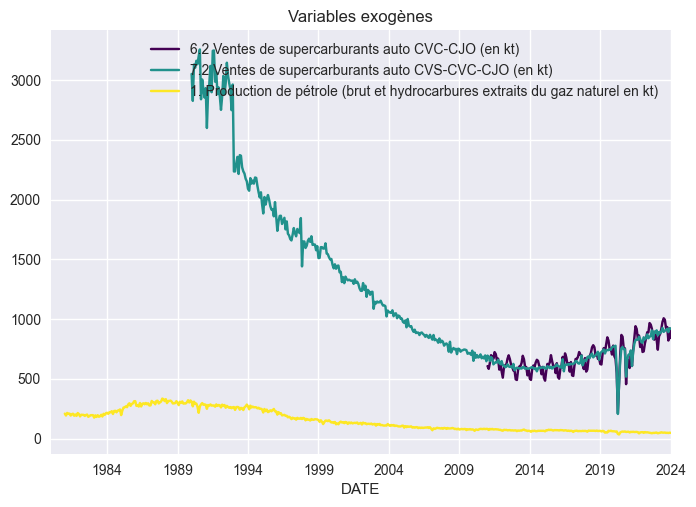

In [253]:
exogenous.plot(title = 'Variables exogènes', colormap= 'viridis',)

In [254]:
exogenous['6.2 Ventes de supercarburants auto CVC-CJO (en kt)'].dropna()

DATE
2011-01-01    606.581
2011-02-01    583.558
2011-03-01    634.814
2011-04-01    698.093
2011-05-01    685.598
               ...   
2023-09-01    923.960
2023-10-01    933.993
2023-11-01    820.833
2023-12-01    922.939
2024-01-01    841.470
Freq: MS, Name: 6.2 Ventes de supercarburants auto CVC-CJO (en kt), Length: 157, dtype: float64

Nous allons supprimer la variable 6.2 Ventes de supercarburants auto CVC-CJO (en kt) pour laquelle les données ne commencent qu'en 2011.

In [255]:
exogenous = exogenous.drop(columns = ['6.2 Ventes de supercarburants auto CVC-CJO (en kt)'])

In [256]:
exogenous = exogenous.dropna()
exogenous

7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)  \
DATE                                                                 
1990-01-01                                           3051.348        
1990-02-01                                           2826.270        
1990-03-01                                           3129.792        
1990-04-01                                           3103.409        
1990-05-01                                           3161.672        
...                                                       ...        
2023-09-01                                            908.254        
2023-10-01                                            918.642        
2023-11-01                                            890.616        
2023-12-01                                            923.830        
2024-01-01                                            919.769        

            1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)  
DATE                                                                                        
1990-01-01                                            309.000                               
1990-02-01                                            270.000                               
1990-03-01                                            309.000                               
1990-04-01                                            291.000                               
1990-05-01                                            293.000                               
...                                                       ...                               
2023-09-01                                             47.751                               
2023-10-01                                             48.609                               
2023-11-01                                             46.800                               
2023-12-01                                             49.329                               
2024-01-01                                             47.948                               

[409 rows x 2 columns]

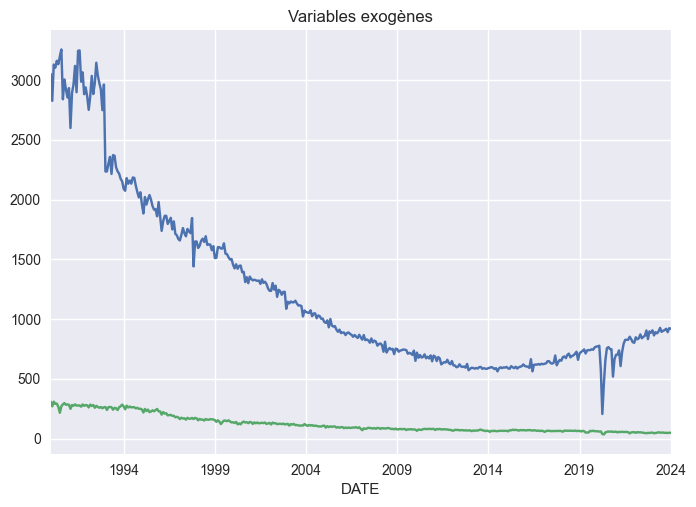

In [257]:
exogenous.plot(title = 'Variables exogènes',legend= False);

Pour plus d'harmonie, nous allons restreindre notre analyse de série temporelle de janvier 1990 à janvier 2024.

## Modèle de base sans variables exogènes

Nous allons tout d'abord étudier un modèle simple sans variables exogènes.

### Train/test split

In [258]:
# Train set
tr_start,tr_end = '1990-01-01','2019-12-01'

# Test set
te_start,te_end = '2020-01-01','2024-01-01'

In [259]:
train_target = data['5.2 Ventes de supercarburants auto (en kt)'].loc[tr_start:tr_end]
test_target = data['5.2 Ventes de supercarburants auto (en kt)'].loc[te_start:te_end]

In [260]:
start = '1990-01'
target = data['5.2 Ventes de supercarburants auto (en kt)'].loc[start:]

In [261]:
train_target = pd.DataFrame(train_target)
test_target = pd.DataFrame(test_target)

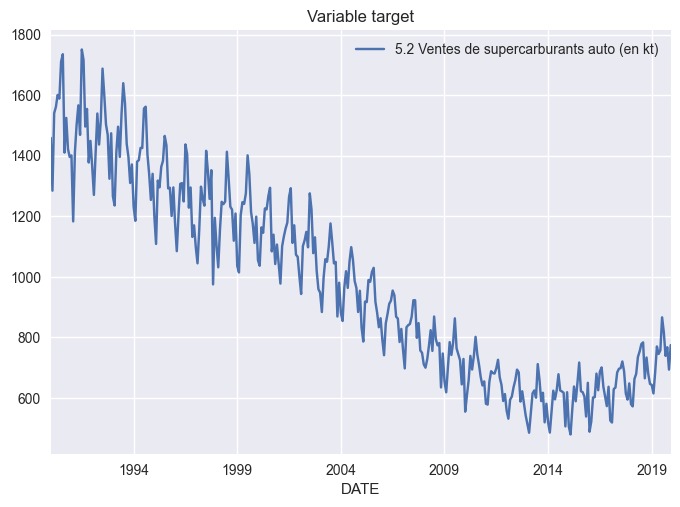

In [262]:
train_target.plot(title = 'Variable target');

### Seasonal decomposition

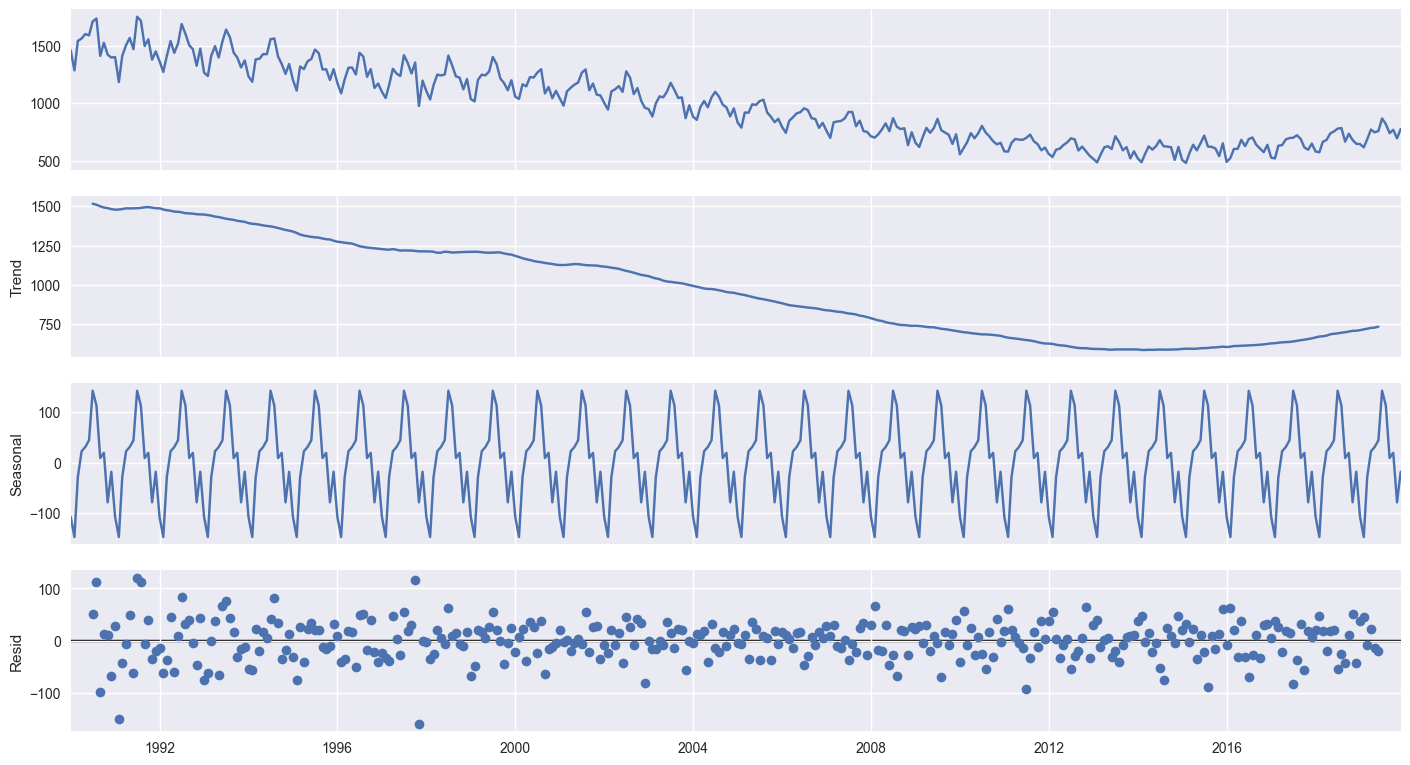

In [263]:
res = sm.tsa.seasonal_decompose(train_target)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

On remarque une saisonnalité annuelle. Une différenciation saisonnière est donc à envisager. 
Les réisdus ont l'air d'être centrés en 0, avec néanmoins quelques outliers en 1990 et 1997. 
La série temporelle semble être additive.

### Check stationarity

In [264]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [265]:
target_diff = train_target.diff().dropna()

In [266]:
# Original Series Stationarity Test
test = {}
print('Original Series Stationarity Test')
adfuller_result = adfuller(train_target)
kpss_result = kpss(train_target)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -1.4635768565711365, p-value: 0.5514462985759355
KPSS Statistic: 2.979882029957785, p-value: 0.01


In [268]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -1.463577  2.979882
p-value    0.551446  0.010000

La série originale est trend stationnaire. elle doit être de-trended. Appliquons le test à la série différenciée.

In [269]:
print('Differenced series Stationarity Test')
adfuller_result = adfuller(target_diff)
kpss_result = kpss(target_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Differenced series Stationarity Test
ADF Statistic: -2.2868106547197997, p-value: 0.17625708883012103
KPSS Statistic: 0.024786531688581335, p-value: 0.1


In [270]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -2.286811  0.024787
p-value    0.176257  0.100000

Toujours pas. Continuons à différencier

In [273]:
target_diff_2 = target_diff.diff().dropna()

In [274]:
print('Original Series Stationarity Test')
adfuller_result = adfuller(target_diff_2)
kpss_result = kpss(target_diff_2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -13.442036105573331, p-value: 3.8284368386418796e-25
KPSS Statistic: 0.009434110617548338, p-value: 0.1


In [275]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -1.344204e+01  0.009434
p-value    3.828437e-25  0.100000

La série 2 fois différenciée est sationnaire. Donc le paramètre d des modèles ARIMA et SARIMA est 2.

### ACF et PACF

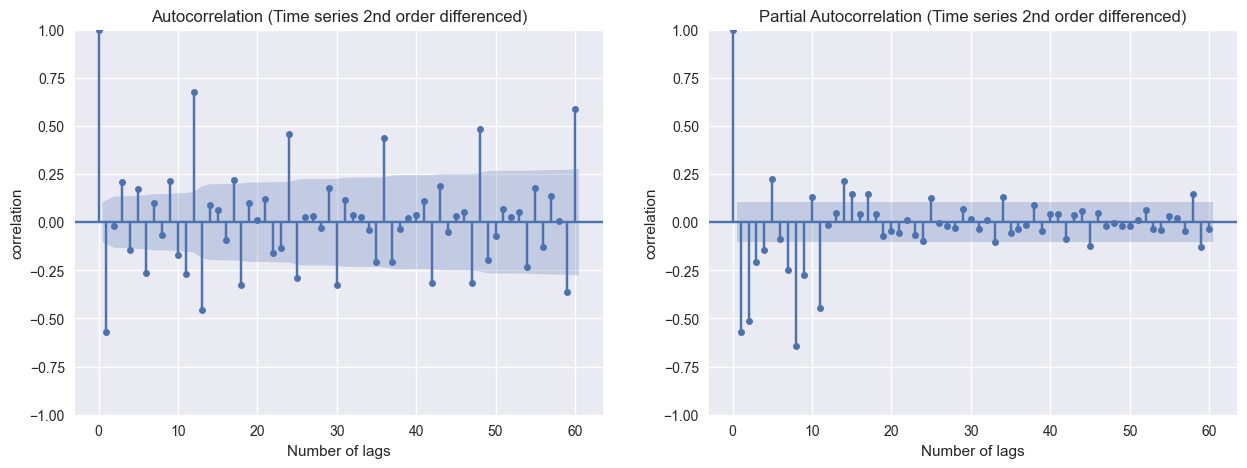

In [278]:
autocorrelation_plots(target_diff_2, 'Time series 2nd order differenced', n_lags=60)

En se basant sur les ACF et PACF de la série différenciée:
- Sur le plot ACF, on remarque que le premier lag à rentrer dans l'intervalle de confiance est le 2e  donc q = 1
- Sur le plot PACF, on remarque que le premier lag à rentrer dans l'intervalle de confiance est le 6e donc p = 5

On remarque aussi la présence de piques récurrents tous les 12 lags dans l'ACF de la série 2 fois différenciée, ce qui accentue la présence d'une saisonnalité.
Nous allons donc différencier la série de manière à éliminer la saisonnalité.



In [279]:
target_diff_seasonal = target_diff_2.diff(12).dropna()

# Stationarity Tests on Combined Differentiated Data
warnings.filterwarnings("ignore")
adfuller_result = adfuller(target_diff_seasonal)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(target_diff_seasonal)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -9.425274149517207, p-value: 5.367564140028849e-16
KPSS Statistic: 0.021857945861506814, p-value: 0.1


In [280]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -9.425274e+00  0.021858
p-value    5.367564e-16  0.100000

La série saisonnièrement différenciée est stationnaire.

In [31]:
def autocorrelation_plots(timeseries, description, n_lags):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_acf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.subplot(122)
    plot_pacf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Partial Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.show()

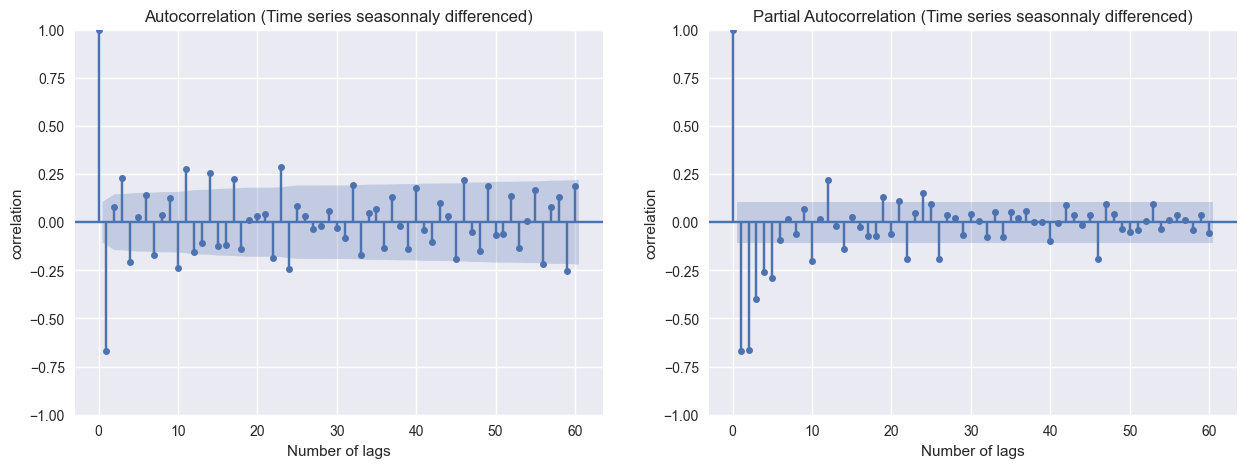

In [32]:
autocorrelation_plots(target_diff_seasonal, 'Time series seasonnaly differenced', n_lags=60)

On trouve P = 5, Q = 1 et D = 1

Donc on aurait un modèle SARIMA(5,2,1)x(5,1,1,12)

### GridSearch to find the best parameters

In [33]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(train_target, #time series
                      seasonal=True, # is the time series seasonal
                      m=12, # the seasonal period 
                      d=2, # non-seasonal difference order
                      D=1, # seasonal difference order
                      start_p = 5,
                      start_q = 1,
                      start_P = 5, 
                      start_Q = 1,
                 	  max_p=5, # max value of p to test 
                      max_q=3, # max value of p to test
                      max_P=5, # max value of P to test 
                      max_Q=3, # max value of Q to test 
                      trace=True, # prints the information_criterion for each model it fits
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic


 ARIMA(5,2,1)(5,1,1)[12]             : AIC=inf, Time=80.09 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=4215.216, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=3997.386, Time=0.19 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=4011.291, Time=0.07 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=3973.164, Time=0.46 sec
 ARIMA(1,2,0)(3,1,0)[12]             : AIC=3947.715, Time=1.09 sec
 ARIMA(1,2,0)(4,1,0)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(1,2,0)(3,1,1)[12]             : AIC=3881.396, Time=3.43 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=3899.172, Time=2.01 sec
 ARIMA(1,2,0)(4,1,1)[12]             : AIC=3819.983, Time=4.70 sec
 ARIMA(1,2,0)(5,1,1)[12]             : AIC=3802.712, Time=46.43 sec
 ARIMA(1,2,0)(5,1,0)[12]             : AIC=inf, Time=13.62 sec
 ARIMA(1,2,0)(5,1,2)[12]             : AIC=inf, Time=62.00 sec
 ARIMA(1,2,0)(4,1,2)[12]             : AIC=inf, Time=13.59 sec
 ARIMA(0,2,0)(5,1,1)

Modèle SARIMA(3,2,0)x(5,1,0,12) trouvé par gridSearch selon le critère AIC

### Models

In [34]:
model1 = sm.tsa.statespace.SARIMAX(train_target,order=(3,2,0),seasonal_order=(5,1,0,12),
                                 enforce_stationarity=True, enforce_invertibility=False,).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  360
Model:                         SARIMAX(3, 2, 0)x(5, 1, 0, 12)   Log Likelihood               -1776.417
Date:                                        Thu, 02 May 2024   AIC                           3570.834
Time:                                                09:16:54   BIC                           3605.452
Sample:                                            01-01-1990   HQIC                          3584.619
                                                 - 12-01-2019                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4163      0.041    -34.380      0.000      -1.497      -1.336
ar.L2         -1.1368      0.052    -21.657      0.000      -1.240      -1.034
ar.L3         -0.4226      0.041    -10.376      0.000      -0.502      -0.343
ar.S.L12      -0.6590      0.053    -12.431      0.000      -0.763      -0.555
ar.S.L24      -0.7389      0.058    -12.770      0.000      -0.852      -0.625
ar.S.L36      -0.5444      0.072     -7.612      0.000      -0.685      -0.404
ar.S.L48      -0.5733      0.050    -11.525      0.000      -0.671      -0.476
ar.S.L60      -0.2071      0.057     -3.610      0.000      -0.320      -0.095
sigma2      1582.9627     96.985     16.322      0.000    1392.875    1773.050
===================================================================================
Ljung-Box (L1) (Q):                   7.45   Jarque-Bera (JB):                34.39
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

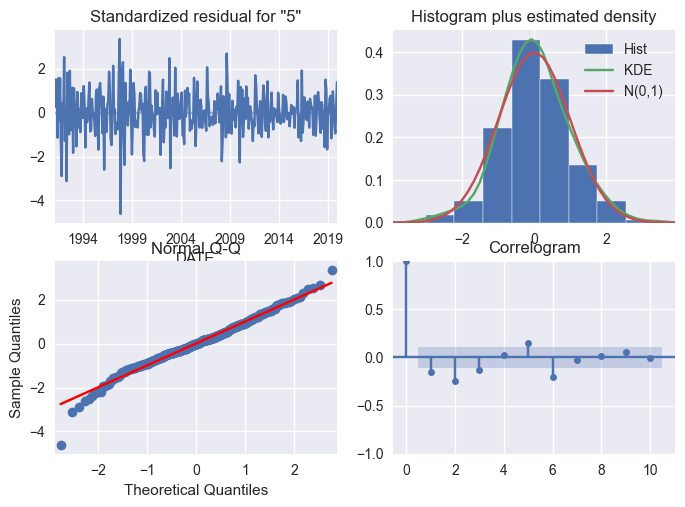

In [35]:
model1.plot_diagnostics()
plt.show()

In [36]:
model2 = sm.tsa.statespace.SARIMAX(train_target,order=(5,2,1),seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()
model2.summary()

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  360
Model:                         SARIMAX(5, 2, 1)x(5, 1, 1, 12)   Log Likelihood               -1700.419
Date:                                        Thu, 02 May 2024   AIC                           3426.838
Time:                                                09:18:18   BIC                           3476.841
Sample:                                            01-01-1990   HQIC                          3446.749
                                                 - 12-01-2019                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9723      0.053    -18.473      0.000      -1.076      -0.869
ar.L2         -0.7036      0.069    -10.164      0.000      -0.839      -0.568
ar.L3         -0.2238      0.080     -2.787      0.005      -0.381      -0.066
ar.L4         -0.0871      0.075     -1.158      0.247      -0.234       0.060
ar.L5         -0.0071      0.056     -0.125      0.900      -0.118       0.104
ma.L1         -1.0094      0.019    -53.583      0.000      -1.046      -0.972
ar.S.L12      -1.4847      0.068    -21.933      0.000      -1.617      -1.352
ar.S.L24      -1.1465      0.086    -13.381      0.000      -1.314      -0.979
ar.S.L36      -1.0098      0.094    -10.703      0.000      -1.195      -0.825
ar.S.L48      -0.8010      0.082     -9.823      0.000      -0.961      -0.641
ar.S.L60      -0.4478      0.049     -9.228      0.000      -0.543      -0.353
ma.S.L12       0.9665      0.122      7.908      0.000       0.727       1.206
sigma2       965.8575     90.706     10.648      0.000     788.076    1143.639
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                30.93
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Prob(Q) = 0.94 > 0.05 so we can't reject the null hypothesis that residuals are uncorrelated => good.
- Prob(JB) = 0 < 0.05 so we reject the null hypothesis that the residuals are normally distributed

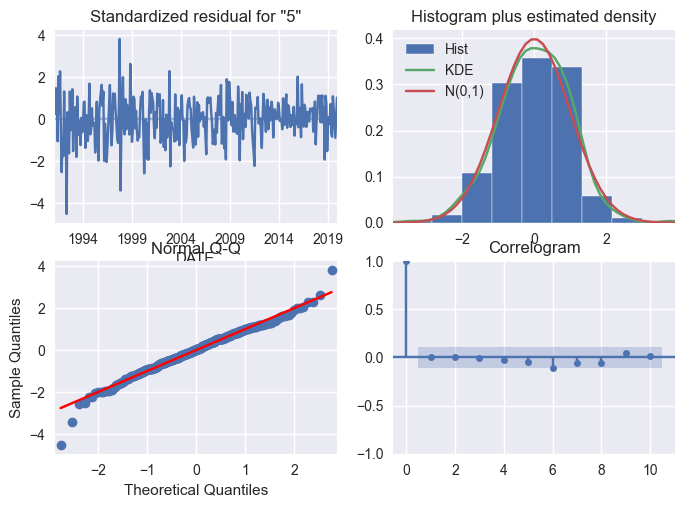

In [37]:
model2.plot_diagnostics()
plt.show()

In [38]:
model3 = sm.tsa.statespace.SARIMAX(train_target,order=(3,2,1),seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  360
Model:                         SARIMAX(3, 2, 1)x(5, 1, 1, 12)   Log Likelihood               -1701.554
Date:                                        Thu, 02 May 2024   AIC                           3425.108
Time:                                                09:19:31   BIC                           3467.419
Sample:                                            01-01-1990   HQIC                          3441.956
                                                 - 12-01-2019                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9572      0.050    -19.073      0.000      -1.056      -0.859
ar.L2         -0.6459      0.060    -10.686      0.000      -0.764      -0.527
ar.L3         -0.1405      0.051     -2.778      0.005      -0.240      -0.041
ma.L1         -0.9926      0.020    -50.540      0.000      -1.031      -0.954
ar.S.L12      -1.4880      0.066    -22.422      0.000      -1.618      -1.358
ar.S.L24      -1.1543      0.083    -13.828      0.000      -1.318      -0.991
ar.S.L36      -1.0203      0.093    -10.925      0.000      -1.203      -0.837
ar.S.L48      -0.8183      0.080    -10.226      0.000      -0.975      -0.661
ar.S.L60      -0.4607      0.047     -9.773      0.000      -0.553      -0.368
ma.S.L12       0.9719      0.138      7.057      0.000       0.702       1.242
sigma2       983.7062    103.626      9.493      0.000     780.602    1186.810
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                27.60
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

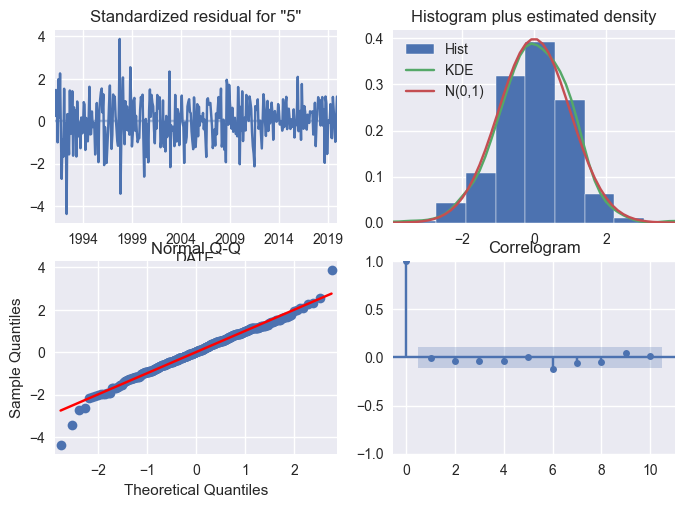

In [39]:
model3.plot_diagnostics()
plt.show()

### Out-of-sample test

#### Test with SARIMA(3,2,0)x(5,1,0)

SARIMA model MSE:145778.44838475916


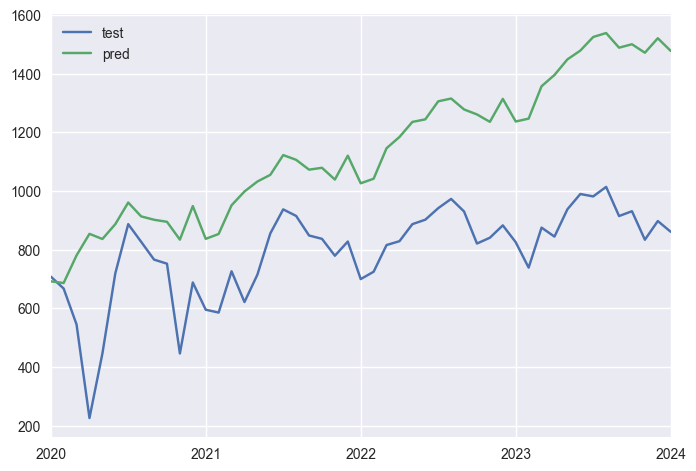

In [40]:
pred1 = model1.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred1)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred1}).plot();plt.show()

#### Test with SARIMA(5,2,1)x(5,1,1)

SARIMA model MSE:17282.339650602575


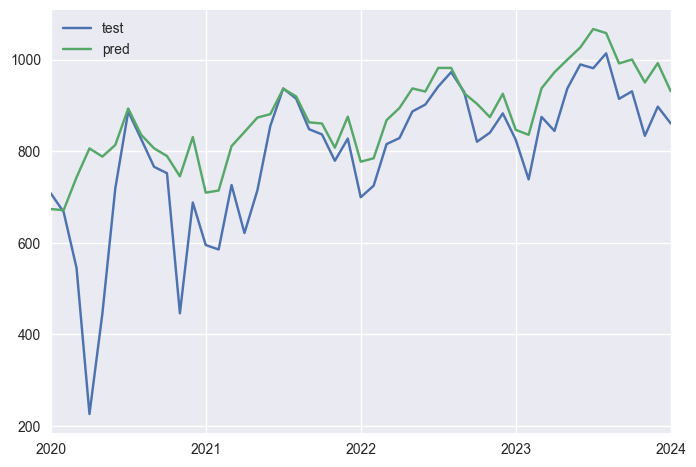

In [41]:
pred2 = model2.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred2)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred2}).plot();plt.show()

#### Test with SARIMA(3,2,1)x(5,1,1)

SARIMA model MSE:16592.823448969684


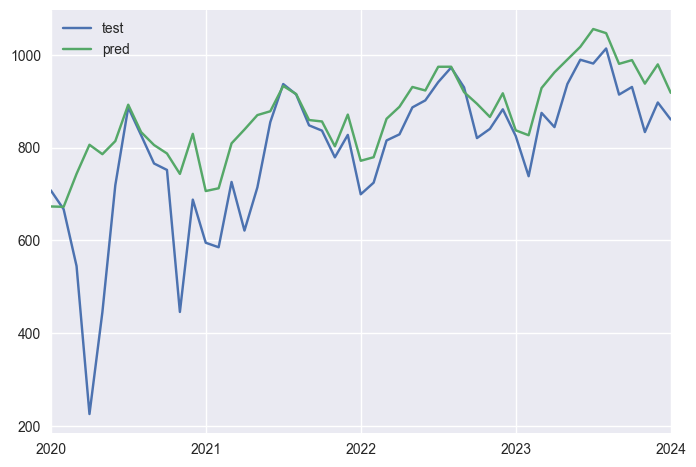

In [42]:
pred3 = model3.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred3)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred3}).plot();plt.show()

=> Modèle final SARIMA(3,2,1)x(5,1,1)

## Ajout de variables exogènes

### Analyse des variables exogènes

In [43]:
exogenous

7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)  \
DATE                                                                 
1990-01-01                                           3051.348        
1990-02-01                                           2826.270        
1990-03-01                                           3129.792        
1990-04-01                                           3103.409        
1990-05-01                                           3161.672        
...                                                       ...        
2023-09-01                                            908.254        
2023-10-01                                            918.642        
2023-11-01                                            890.616        
2023-12-01                                            923.830        
2024-01-01                                            919.769        

            1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)  
DATE                                                                                        
1990-01-01                                            309.000                               
1990-02-01                                            270.000                               
1990-03-01                                            309.000                               
1990-04-01                                            291.000                               
1990-05-01                                            293.000                               
...                                                       ...                               
2023-09-01                                             47.751                               
2023-10-01                                             48.609                               
2023-11-01                                             46.800                               
2023-12-01                                             49.329                               
2024-01-01                                             47.948                               

[409 rows x 2 columns]

In [44]:
exo1 = exogenous.iloc[:,0]
exo2 = exogenous.iloc[:,1]

In [45]:
train_exo1, train_exo2 = exogenous.iloc[:,0].loc[tr_start:tr_end], exogenous.iloc[:,1].loc[tr_start:tr_end]
test_exo1, test_exo2 = exogenous.iloc[:,0].loc[te_start:te_end], exogenous.iloc[:,1].loc[te_start:te_end]

In [88]:
train_exogenous = pd.concat([train_exo1, train_exo2], axis = 1)
test_exogenous = pd.concat([test_exo1, test_exo2], axis = 1)

Plotting the data

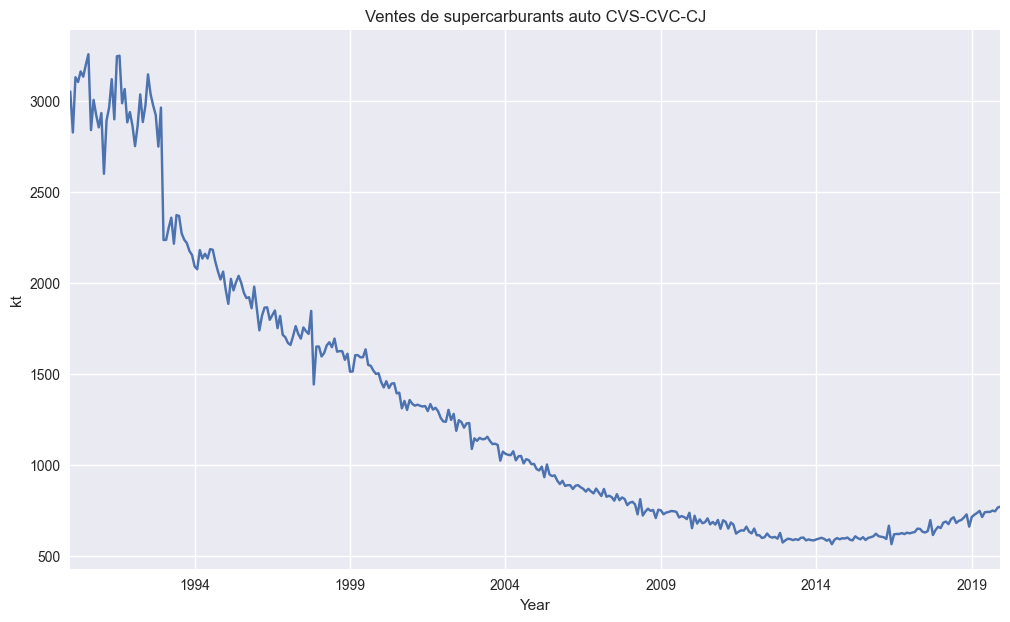

In [46]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
train_exo1.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('kt')
plt.title('Ventes de supercarburants auto CVS-CVC-CJ')
plt.show()

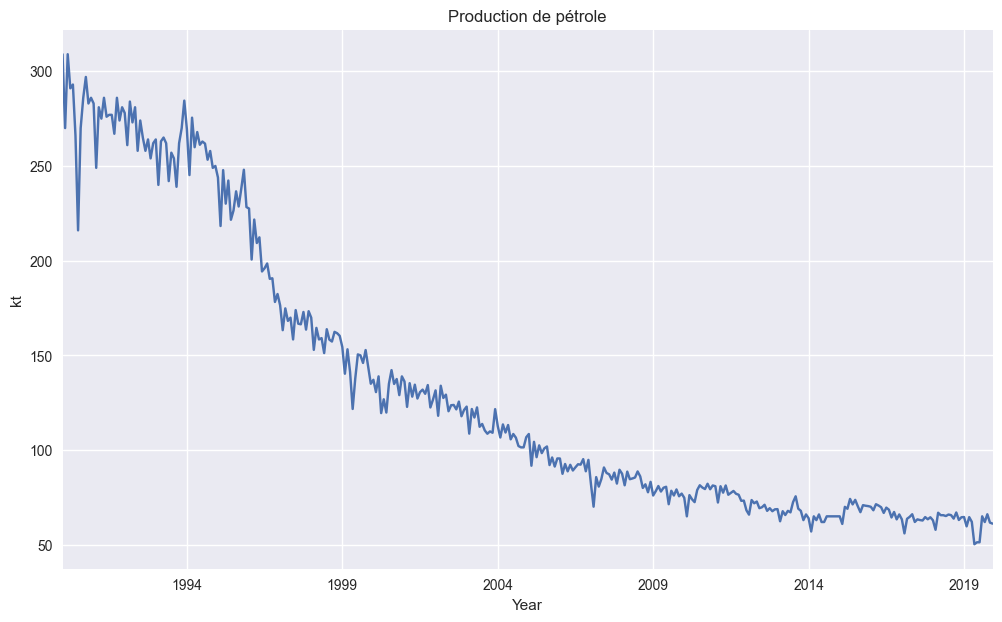

In [47]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
train_exo2.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('kt')
plt.title('Production de pétrole')
plt.show()

### Seasonal decomposition

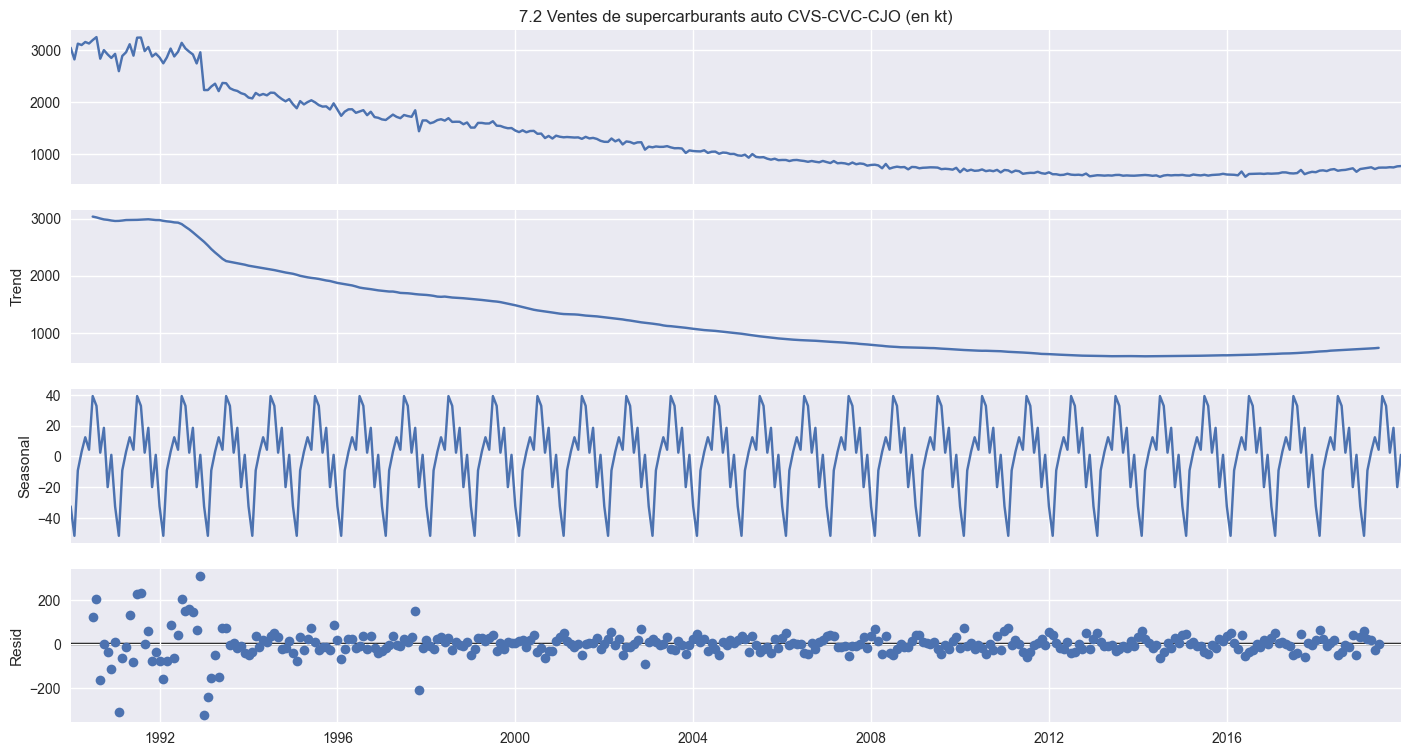

In [48]:
res = sm.tsa.seasonal_decompose(train_exo1)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

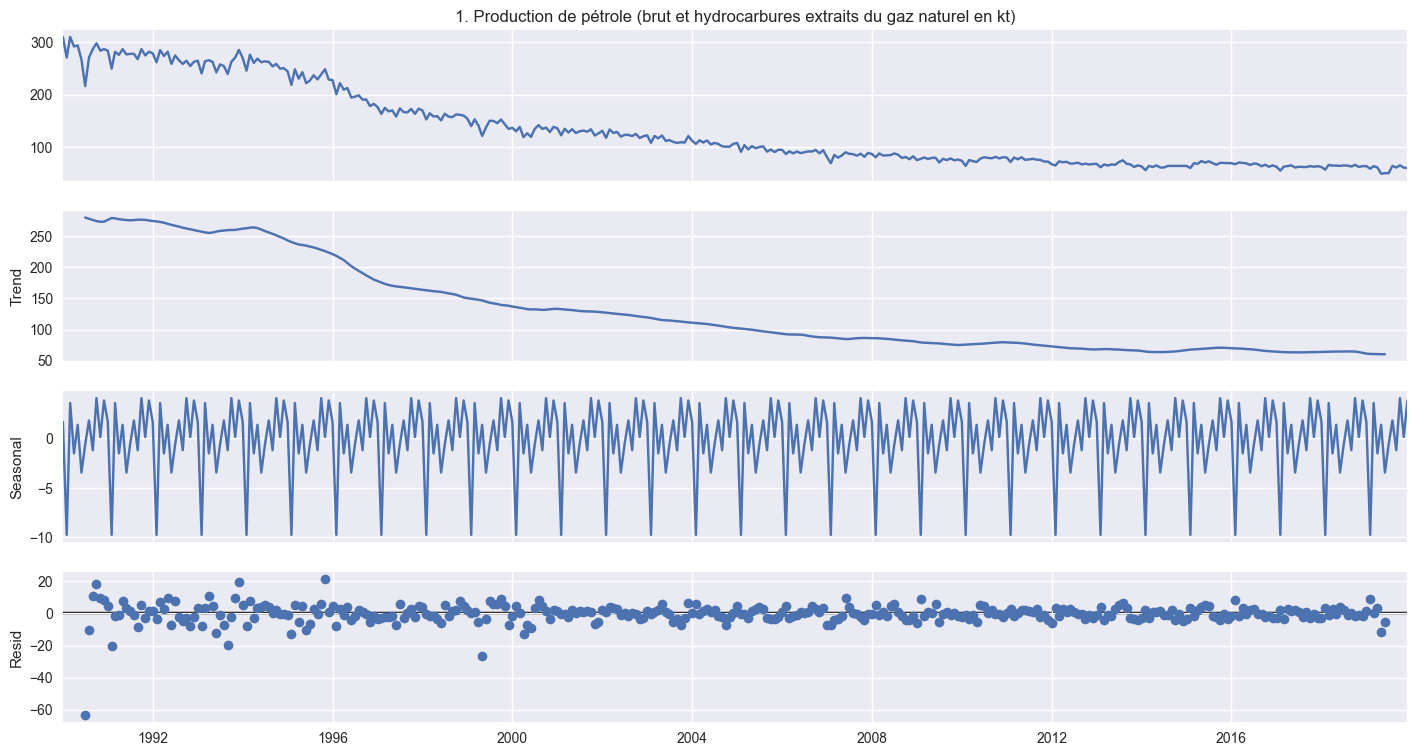

In [49]:
res = sm.tsa.seasonal_decompose(train_exo2)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Check stationarity

EXO1

In [50]:
# Original Series Stationarity Test
print('Original Series Stationarity Test')
adfuller_result = adfuller(train_exo1)
kpss_result = kpss(train_exo1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -2.7456531165994407, p-value: 0.066465929934521
KPSS Statistic: 2.6751736169460747, p-value: 0.01


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\3110999018.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_exo1)


In [51]:
train_exo1_diff = train_exo1.diff().dropna()

In [52]:
# First order differenced Stationary Test
print('First order differenced Series Stationarity Test')
adfuller_result = adfuller(train_exo1_diff)
kpss_result = kpss(train_exo1_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

First order differenced Series Stationarity Test
ADF Statistic: -3.4235900720975505, p-value: 0.01018049813833609
KPSS Statistic: 0.4592229459106464, p-value: 0.05162804055575588


EXO2

In [53]:
# Original Series Stationarity Test
print('Original Series Stationarity Test')
adfuller_result = adfuller(train_exo2)
kpss_result = kpss(train_exo2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -2.4315284782593136, p-value: 0.13303471201223865
KPSS Statistic: 2.7419506598099566, p-value: 0.01


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\2337671819.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_exo2)


In [54]:
train_exo2_diff = train_exo2.diff().dropna()

In [55]:
# First order differenced Stationary Test
print('First order differenced Series Stationarity Test')
adfuller_result = adfuller(train_exo2_diff)
kpss_result = kpss(train_exo2_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

First order differenced Series Stationarity Test
ADF Statistic: -4.8303240032983785, p-value: 4.7568785172994164e-05
KPSS Statistic: 0.5376334761090273, p-value: 0.03319065853400285


Both time series are stationary at the 1st order

### ACF et PACF

EXO1

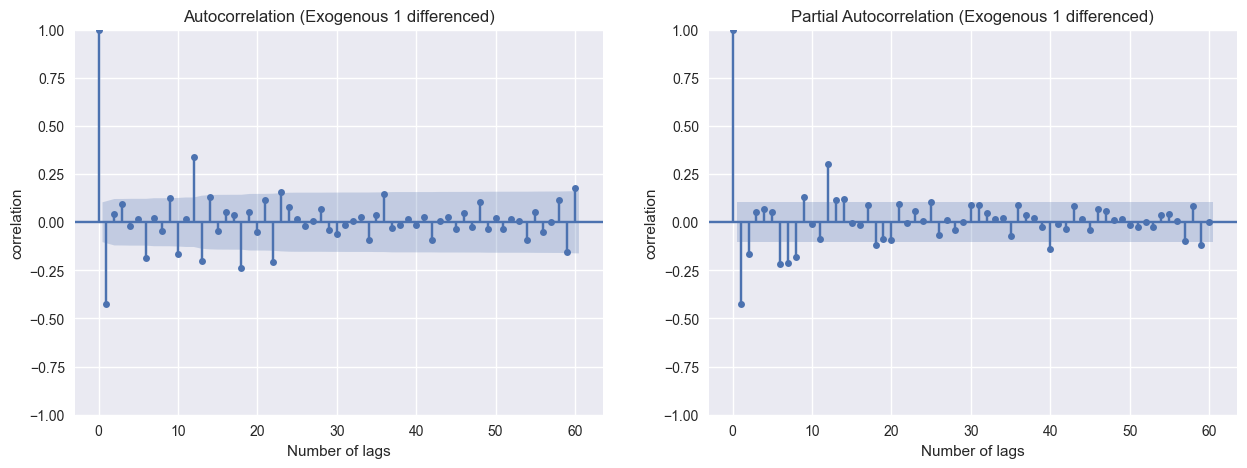

In [56]:
autocorrelation_plots(train_exo1_diff, 'Exogenous 1 differenced', n_lags=60)

- On remarque un petit signe de saisonnalité
- On trouve p = 2 et q = 1

In [57]:
train_exo1_diff_seasonal = train_exo1_diff.diff(12).dropna()

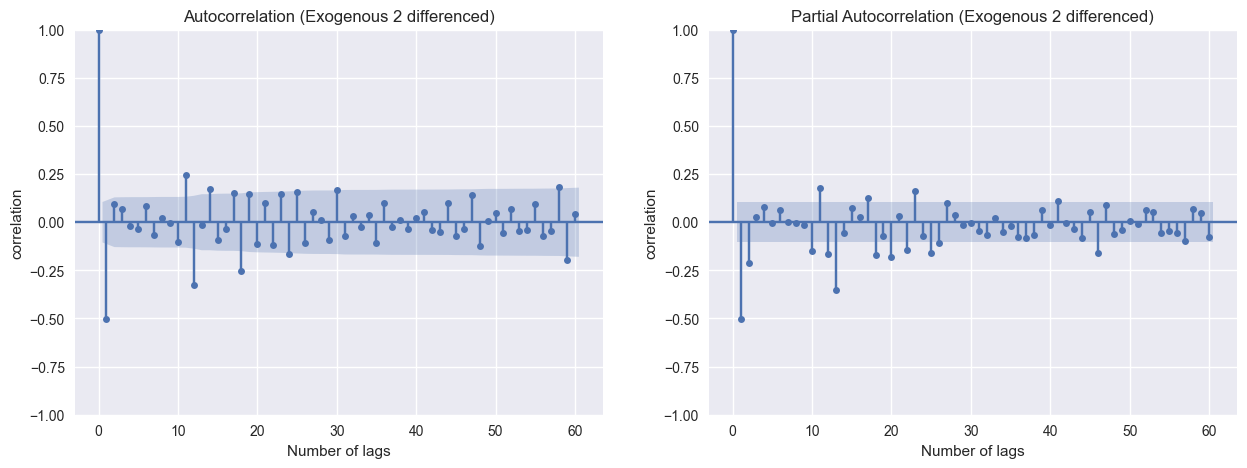

In [58]:
autocorrelation_plots(train_exo1_diff_seasonal, 'Exogenous 1 differenced', n_lags=60)

- On trouve Q = 1, P =2

EXO2

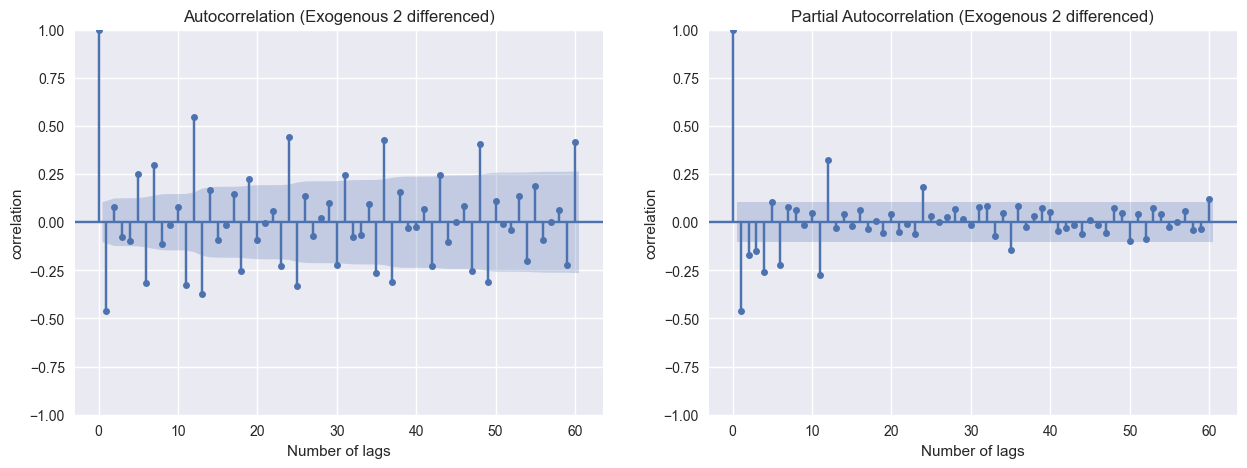

In [59]:
autocorrelation_plots(train_exo2_diff, 'Exogenous 2 differenced', n_lags=60)

- Pics significatifs tous les 12 lags => indique une saisonnalité => plutôt modèle SARIMA
- on trouve p = 4, q = 1

In [60]:
train_exo2_diff_seasonal = train_exo2_diff.diff(12).dropna()

In [61]:
# First seasonal order differenced Stationary Test
print('First order differenced Series Stationarity Test')
adfuller_result = adfuller(train_exo2_diff_seasonal)
kpss_result = kpss(train_exo2_diff_seasonal)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

First order differenced Series Stationarity Test
ADF Statistic: -7.501704168495835, p-value: 4.2367194434647734e-11
KPSS Statistic: 0.028378406826260104, p-value: 0.1


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\2726244121.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_exo2_diff_seasonal)


Seasonal ACF

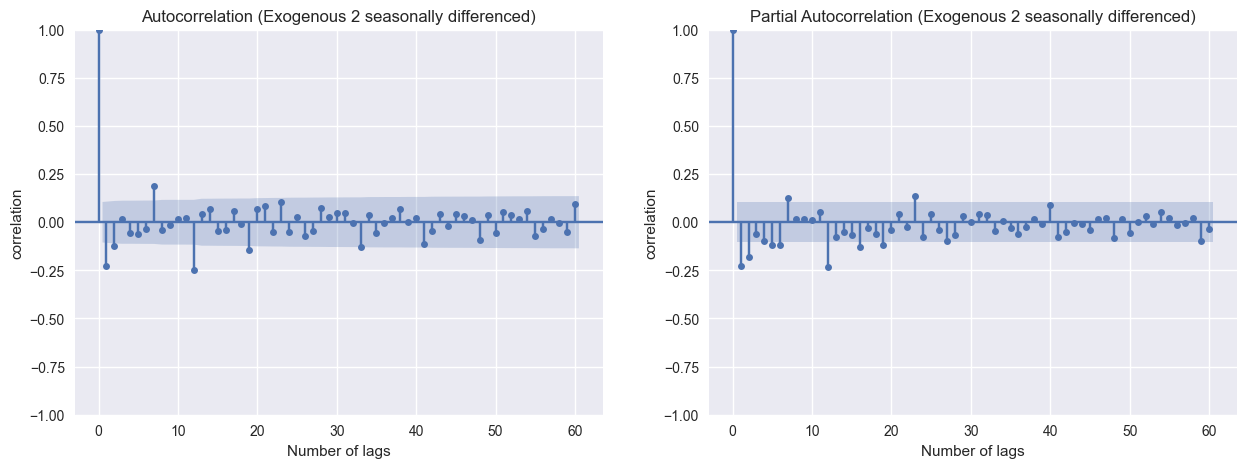

In [62]:
autocorrelation_plots(train_exo2_diff_seasonal, 'Exogenous 2 seasonally differenced', n_lags=60)

On trouve P = 2, Q = 2

### Models

In [63]:
model_exo1 = sm.tsa.statespace.SARIMAX(train_exo1,order=(2,1,1), seasonal_order = (2,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()
model_exo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                 SARIMAX Results                                                  
==================================================================================================================
Dep. Variable:     7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)   No. Observations:                  360
Model:                                     SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1927.698
Date:                                                    Thu, 02 May 2024   AIC                           3869.396
Time:                                                            09:19:40   BIC                           3896.341
Sample:                                                        01-01-1990   HQIC                          3880.124
                                                             - 12-01-2019                                         
Covariance Type:                                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7643      0.138     -5.552      0.000      -1.034      -0.494
ar.L2         -0.3175      0.069     -4.589      0.000      -0.453      -0.182
ma.L1          0.1497      0.145      1.035      0.301      -0.134       0.433
ar.S.L12      -0.1781      0.059     -3.037      0.002      -0.293      -0.063
ar.S.L24      -0.2772      0.037     -7.554      0.000      -0.349      -0.205
ma.S.L12      -0.4846      0.073     -6.612      0.000      -0.628      -0.341
sigma2      3796.8906    141.680     26.799      0.000    3519.202    4074.579
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4495.90
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

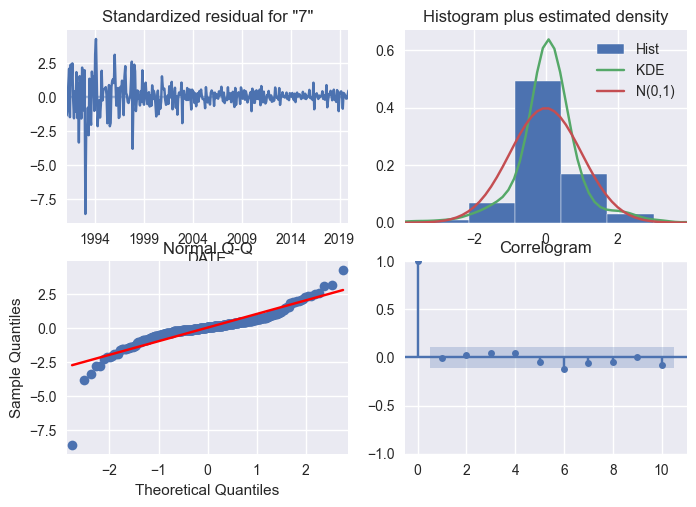

In [64]:
model_exo1.plot_diagnostics()
plt.show()

In [65]:
model_exo2 = sm.tsa.statespace.SARIMAX(train_exo2,order=(2,1,1), seasonal_order = (2,1,2,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()
model_exo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                             SARIMAX Results                                                              
==========================================================================================================================================
Dep. Variable:     1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)   No. Observations:                  360
Model:                                                        SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1160.122
Date:                                                                            Thu, 02 May 2024   AIC                           2336.243
Time:                                                                                    09:19:45   BIC                           2367.038
Sample:                                                                                01-01-1990   HQIC                          2348.505
                                                                                     - 12-01-2019                                         
Covariance Type:                                                                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3773      0.101      3.743      0.000       0.180       0.575
ar.L2         -0.0418      0.054     -0.769      0.442      -0.149       0.065
ma.L1         -0.7201      0.101     -7.153      0.000      -0.917      -0.523
ar.S.L12      -0.6316      0.731     -0.863      0.388      -2.065       0.802
ar.S.L24       0.0240      0.109      0.221      0.825      -0.189       0.237
ma.S.L12      -0.0081      0.739     -0.011      0.991      -1.457       1.441
ma.S.L24      -0.5124      0.550     -0.932      0.351      -1.590       0.565
sigma2        45.8515      1.768     25.931      0.000      42.386      49.317
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1918.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

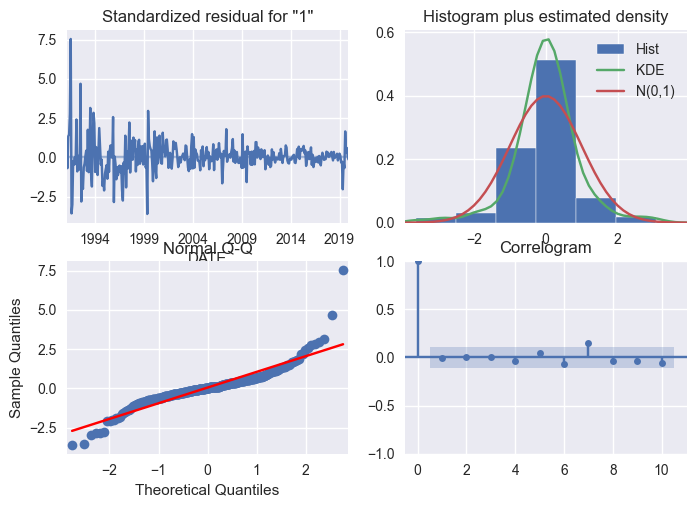

In [66]:
model_exo2.plot_diagnostics()
plt.show()

### Out-of-sample test

SARIMA model MSE:14925.160561295808


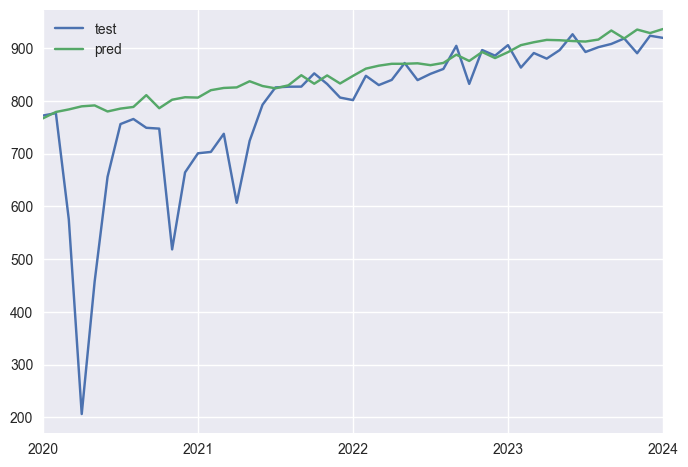

In [67]:
pred_exo1 = model_exo1.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_exo1,pred_exo1)))

pd.DataFrame({'test':test_exo1.values.flatten(),'pred': pred_exo1}).plot();plt.show()

SARIMA model MSE:44.59802659068962


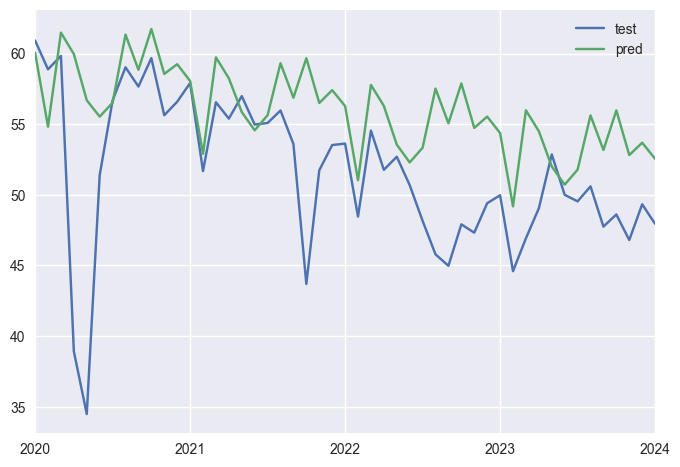

In [68]:
pred_exo2 = model_exo2.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_exo2,pred_exo2)))

pd.DataFrame({'test':test_exo2.values.flatten(),'pred':pred_exo2}).plot();plt.show()

### Get Full forecast for exogenous variables

Forecast for EXO1

In [287]:
final_model_exo1 = sm.tsa.statespace.SARIMAX(exo1,order=(2,1,1), seasonal_order = (2,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()

In [288]:
pred_exo1 = final_model_exo1.forecast(steps = 12)
pred_exo1

2024-01-01    2487.044268
2024-02-01    2479.345023
2024-03-01    2399.534896
2024-04-01    2207.833726
2024-05-01    2403.324485
2024-06-01    2439.913186
2024-07-01    2461.956631
2024-08-01    2478.584782
2024-09-01    2478.297519
2024-10-01    2457.425750
2024-11-01    2412.687861
2024-12-01    2416.930009
Freq: MS, Name: predicted_mean, dtype: float64

In [289]:
final_model_exo2 = sm.tsa.statespace.SARIMAX(exo2,order=(2,1,1), seasonal_order = (2,1,2,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [290]:
pred_exo2 = final_model_exo2.forecast(steps = 12)
pred_exo2

2024-01-01    3105.695699
2024-02-01    2994.600488
2024-03-01    3312.792579
2024-04-01    2976.350826
2024-05-01    3216.418605
2024-06-01    3454.913503
2024-07-01    3670.971824
2024-08-01    3364.975866
2024-09-01    3343.625876
2024-10-01    3515.438694
2024-11-01    3123.976025
2024-12-01    3341.038416
Freq: MS, Name: predicted_mean, dtype: float64

## Modèle avec Variables exogènes

### Utilisation de la variable EXO1

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
model3_with_exo1 = sm.tsa.statespace.SARIMAX(train_target,order=(3,2,1), seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=train_exo1).fit()
model3_with_exo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  360
Model:                         SARIMAX(3, 2, 1)x(5, 1, 1, 12)   Log Likelihood               -1604.815
Date:                                        Thu, 02 May 2024   AIC                           3233.631
Time:                                                19:36:50   BIC                           3279.788
Sample:                                            01-01-1990   HQIC                          3252.011
                                                 - 12-01-2019                                         
Covariance Type:                                          opg                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)     0.3859      0.012     32.310      0.000       0.362       0.409
ar.L1                                                     -0.6041      0.042    -14.432      0.000      -0.686      -0.522
ar.L2                                                     -0.2067      0.058     -3.539      0.000      -0.321      -0.092
ar.L3                                                      0.1623      0.053      3.043      0.002       0.058       0.267
ma.L1                                                     -0.9954      0.026    -38.797      0.000      -1.046      -0.945
ar.S.L12                                                  -1.5083      0.066    -22.879      0.000      -1.637      -1.379
ar.S.L24                                                  -1.1497      0.093    -12.332      0.000      -1.332      -0.967
ar.S.L36                                                  -1.0494      0.102    -10.275      0.000      -1.250      -0.849
ar.S.L48                                                  -0.9542      0.075    -12.683      0.000      -1.102      -0.807
ar.S.L60                                                  -0.5371      0.041    -13.167      0.000      -0.617      -0.457
ma.S.L12                                                   0.9584      0.099      9.714      0.000       0.765       1.152
sigma2                                                   565.1976     48.250     11.714      0.000     470.629     659.766
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               123.35
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

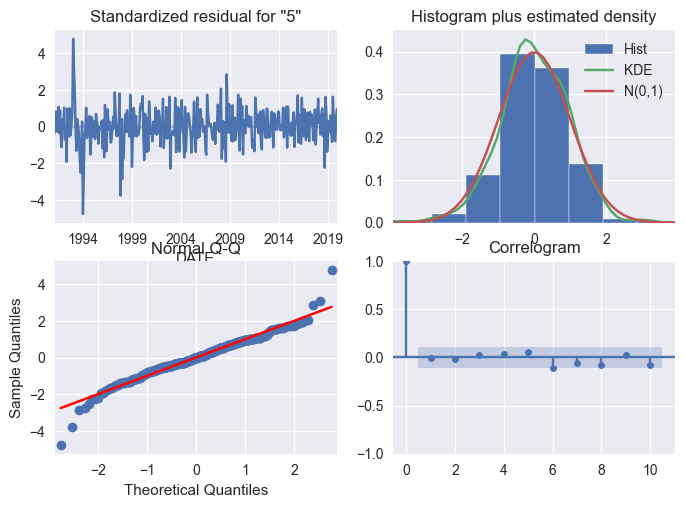

In [80]:
model3_with_exo1.plot_diagnostics()
plt.show()

SARIMA model MSE:5660.937880806752


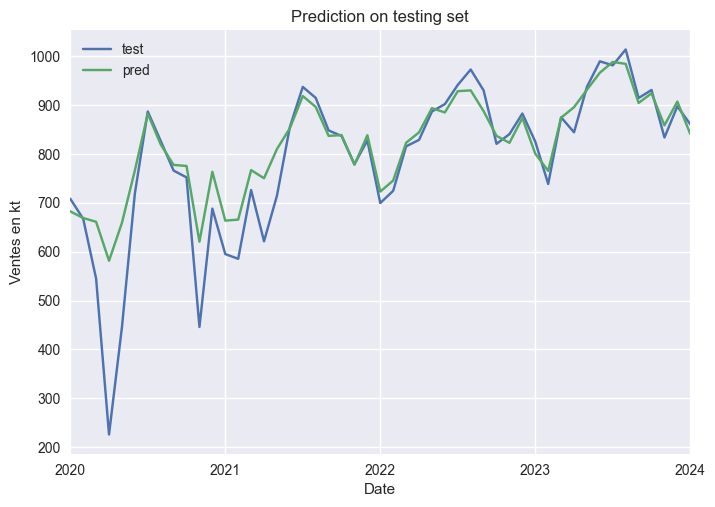

In [85]:
pred_model3_with_exo1 = model3_with_exo1.predict(tr_end,te_end,exog=test_exo1)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred_model3_with_exo1)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred_model3_with_exo1}).plot(title = 'Prediction on testing set', xlabel = 'Date', ylabel = 'Ventes en kt');plt.show()

Grande amélioration de la MSE avec l'ajout de l'EXO1

### Utilisation de la variable EXO2

In [82]:
model3_with_exo2 = sm.tsa.statespace.SARIMAX(train_target,order=(3,2,1), seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=train_exo2).fit()
model3_with_exo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  360
Model:                         SARIMAX(3, 2, 1)x(5, 1, 1, 12)   Log Likelihood               -1701.324
Date:                                        Thu, 02 May 2024   AIC                           3426.648
Time:                                                19:40:30   BIC                           3472.805
Sample:                                            01-01-1990   HQIC                          3445.028
                                                 - 12-01-2019                                         
Covariance Type:                                          opg                                         
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)     0.1175      0.157      0.750      0.453      -0.190       0.425
ar.L1                                                                             -0.9554      0.051    -18.664      0.000      -1.056      -0.855
ar.L2                                                                             -0.6471      0.061    -10.638      0.000      -0.766      -0.528
ar.L3                                                                             -0.1410      0.051     -2.753      0.006      -0.241      -0.041
ma.L1                                                                             -0.9924      0.020    -50.707      0.000      -1.031      -0.954
ar.S.L12                                                                          -1.4823      0.067    -22.048      0.000      -1.614      -1.351
ar.S.L24                                                                          -1.1487      0.084    -13.745      0.000      -1.313      -0.985
ar.S.L36                                                                          -1.0156      0.093    -10.915      0.000      -1.198      -0.833
ar.S.L48                                                                          -0.8120      0.081    -10.070      0.000      -0.970      -0.654
ar.S.L60                                                                          -0.4579      0.048     -9.562      0.000      -0.552      -0.364
ma.S.L12                                                                           0.9667      0.124      7.809      0.000       0.724       1.209
sigma2                                                                           985.2921     94.327     10.446      0.000     800.415    1170.169
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                26.77
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

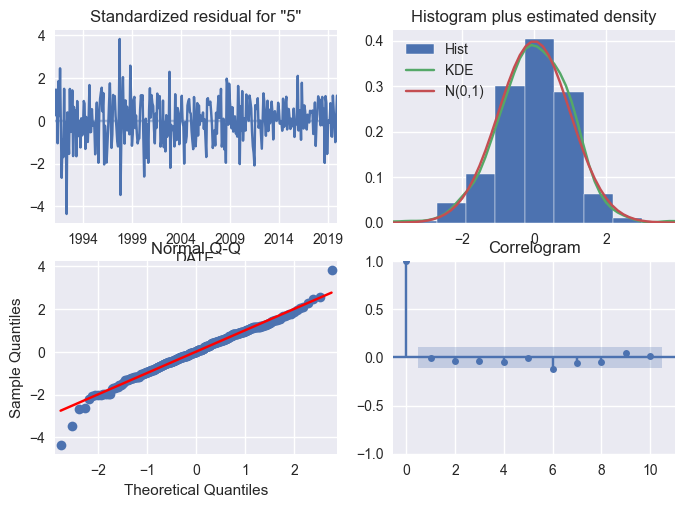

In [83]:
model3_with_exo2.plot_diagnostics()
plt.show()

SARIMA model MSE:16426.303237025528


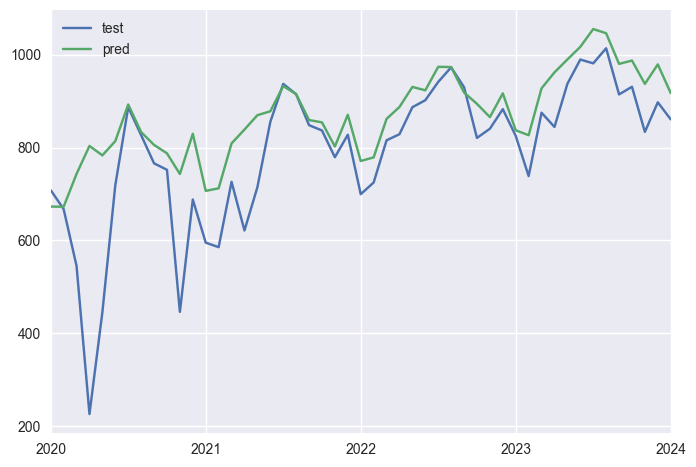

In [77]:
pred_model3_with_exo2 = model3_with_exo2.predict(tr_end,te_end,exog=test_exo2)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred_model3_with_exo2)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred_model3_with_exo2}).plot();plt.show()

MSE plus grande qu'avec l'ajout d'EXO1

### Utilisation des deux variables exogènes

In [89]:
model3_with_exogenous = sm.tsa.statespace.SARIMAX(train_target,order=(3,2,1), seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=train_exogenous).fit()
model3_with_exogenous.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  360
Model:                         SARIMAX(3, 2, 1)x(5, 1, 1, 12)   Log Likelihood               -1603.102
Date:                                        Thu, 02 May 2024   AIC                           3232.205
Time:                                                19:48:01   BIC                           3282.208
Sample:                                            01-01-1990   HQIC                          3252.116
                                                 - 12-01-2019                                         
Covariance Type:                                          opg                                         
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)                             0.3913      0.012     32.561      0.000       0.368       0.415
1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)     0.3088      0.189      1.631      0.103      -0.062       0.680
ar.L1                                                                             -0.5866      0.043    -13.764      0.000      -0.670      -0.503
ar.L2                                                                             -0.1957      0.059     -3.321      0.001      -0.311      -0.080
ar.L3                                                                              0.1736      0.053      3.257      0.001       0.069       0.278
ma.L1                                                                             -0.9958      0.028    -35.634      0.000      -1.051      -0.941
ar.S.L12                                                                          -1.4986      0.065    -23.078      0.000      -1.626      -1.371
ar.S.L24                                                                          -1.1384      0.093    -12.248      0.000      -1.321      -0.956
ar.S.L36                                                                          -1.0362      0.102    -10.195      0.000      -1.235      -0.837
ar.S.L48                                                                          -0.9380      0.076    -12.344      0.000      -1.087      -0.789
ar.S.L60                                                                          -0.5307      0.041    -12.829      0.000      -0.612      -0.450
ma.S.L12                                                                           0.9520      0.090     10.617      0.000       0.776       1.128
sigma2                                                                           561.5740     46.353     12.115      0.000     470.725     652.423
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               125.25
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

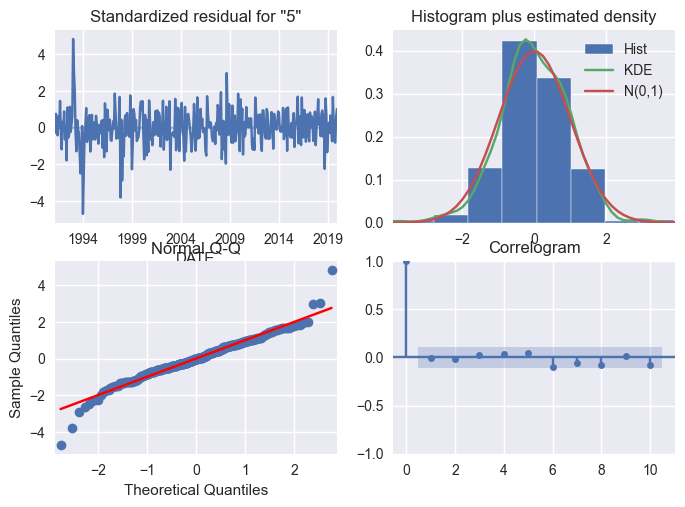

In [285]:
model3_with_exogenous.plot_diagnostics()
plt.show()

SARIMA model MSE:5378.501291712602


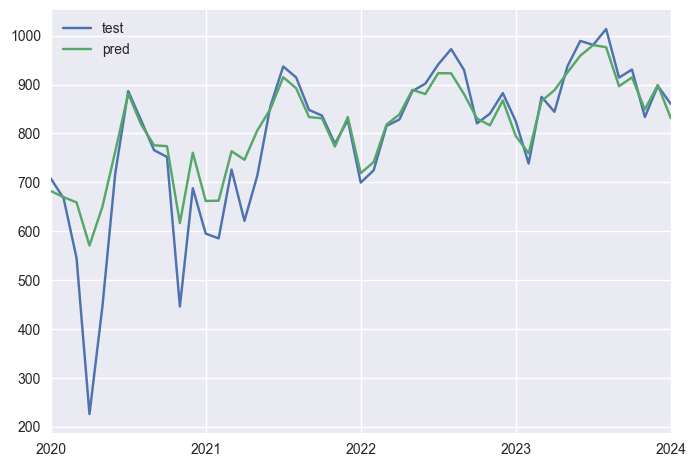

In [91]:
pred_model3_with_exogenous = model3_with_exogenous.predict(tr_end,te_end,exog=test_exogenous)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred_model3_with_exogenous)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred_model3_with_exogenous}).plot();plt.show()

## Prédictions finales

In [291]:
pred_exogenous = pd.concat([pred_exo1, pred_exo2], axis = 1)
pred_exogenous

predicted_mean  predicted_mean
2024-01-01     2487.044268     3105.695699
2024-02-01     2479.345023     2994.600488
2024-03-01     2399.534896     3312.792579
2024-04-01     2207.833726     2976.350826
2024-05-01     2403.324485     3216.418605
2024-06-01     2439.913186     3454.913503
2024-07-01     2461.956631     3670.971824
2024-08-01     2478.584782     3364.975866
2024-09-01     2478.297519     3343.625876
2024-10-01     2457.425750     3515.438694
2024-11-01     2412.687861     3123.976025
2024-12-01     2416.930009     3341.038416

In [293]:
final_model_target = sm.tsa.statespace.SARIMAX(target,order=(3,2,1), seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=exogenous).fit()
final_model_target.summary()

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     5.2 Ventes de supercarburants auto (en kt)   No. Observations:                  409
Model:                         SARIMAX(3, 2, 1)x(5, 1, 1, 12)   Log Likelihood               -1909.866
Date:                                        Fri, 03 May 2024   AIC                           3845.732
Time:                                                19:35:42   BIC                           3897.458
Sample:                                            01-01-1990   HQIC                          3866.227
                                                 - 01-01-2024                                         
Covariance Type:                                          opg                                         
==================================================================================================================================================
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
7.2 Ventes de supercarburants auto CVS-CVC-CJO (en kt)                             0.5889      0.010     61.842      0.000       0.570       0.608
1. Production de pétrole (brut et hydrocarbures extraits du gaz naturel en kt)     0.8188      0.265      3.096      0.002       0.300       1.337
ar.L1                                                                             -0.2982      0.041     -7.329      0.000      -0.378      -0.218
ar.L2                                                                             -0.0857      0.036     -2.398      0.016      -0.156      -0.016
ar.L3                                                                              0.0951      0.053      1.806      0.071      -0.008       0.198
ma.L1                                                                             -0.9999      1.188     -0.841      0.400      -3.329       1.329
ar.S.L12                                                                          -1.5143      0.061    -24.715      0.000      -1.634      -1.394
ar.S.L24                                                                          -1.1256      0.099    -11.384      0.000      -1.319      -0.932
ar.S.L36                                                                          -1.0450      0.104    -10.059      0.000      -1.249      -0.841
ar.S.L48                                                                          -1.0057      0.067    -15.001      0.000      -1.137      -0.874
ar.S.L60                                                                          -0.5625      0.028    -19.799      0.000      -0.618      -0.507
ma.S.L12                                                                           0.9598      0.069     13.936      0.000       0.825       1.095
sigma2                                                                           848.3942   1018.018      0.833      0.405   -1146.884    2843.672
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2713.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.51
Prob(H) (two-sided):                  0.20   Kurtosis:                        15.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

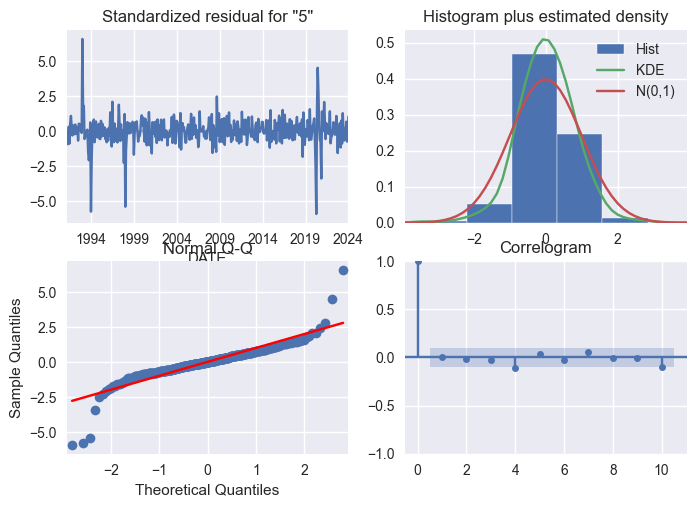

In [104]:
final_model_target.plot_diagnostics();
plt.show()

## Plot the final forecast

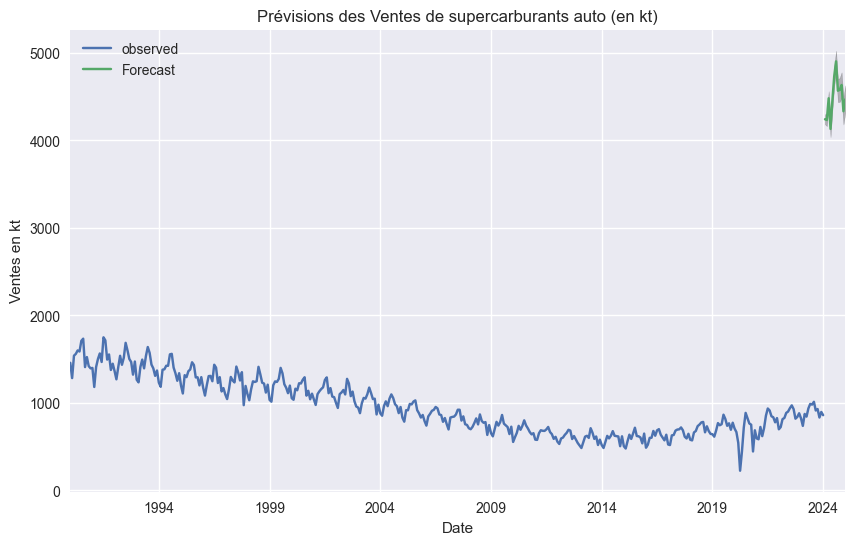

In [295]:
final_forecast = final_model_target.get_forecast(steps = 12, exog = pred_exogenous)
final_forecast_ci = final_forecast.conf_int()

ax = target.plot(label='observed', figsize=(10, 6))
final_forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(final_forecast_ci.index,
                final_forecast_ci.iloc[:, 0],
                final_forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Prévisions des Ventes de supercarburants auto (en kt)')
ax.set_xlabel('Date')
ax.set_ylabel('Ventes en kt')

plt.legend()
plt.show()

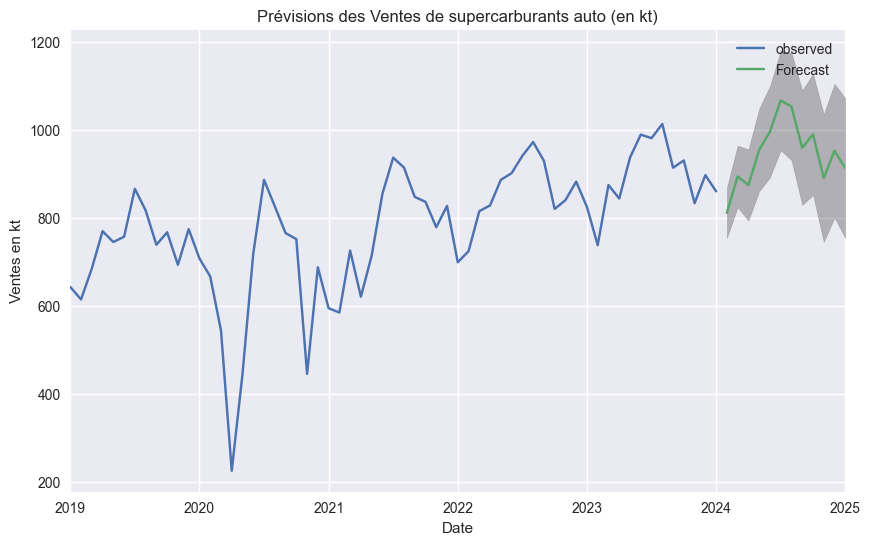

In [286]:
ax = target.loc['2019-01-01':].plot(label='observed', figsize=(10, 6))
final_forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(final_forecast_ci.index,
                final_forecast_ci.iloc[:, 0],
                final_forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Prévisions des Ventes de supercarburants auto (en kt)')
ax.set_xlabel('Date')
ax.set_ylabel('Ventes en kt')

plt.legend()
plt.show()

# Prédiction de la vente de gazole (en kt)

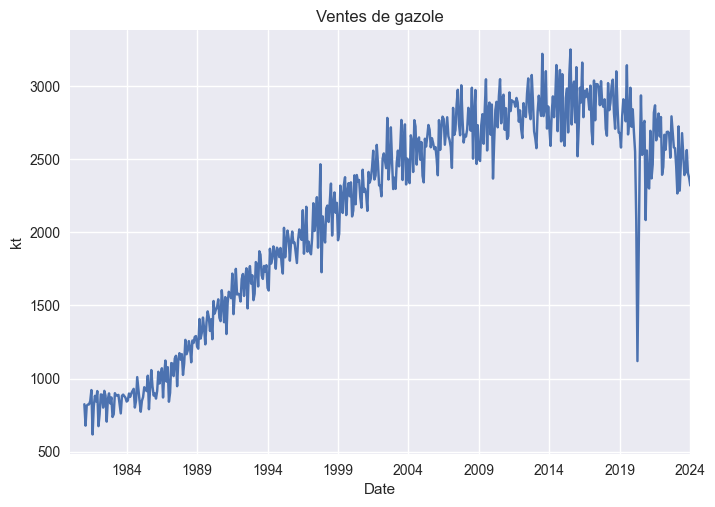

In [353]:
target_2 = data['5.3 Ventes de gazole (en kt)']
target_2.plot(title = 'Ventes de gazole', xlabel = 'Date', ylabel = 'kt');

In [354]:
import numpy as np

# Convertir toutes les colonnes potentiellement numériques
numeric_cols = data.columns[1:]  # Éviter la colonne 'Période' 
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculer les coefficients de corrélation de Pearson entre les ventes de supercarburants et les autres variables numériques
correlation_matrix = data.corr()
correlations_with_vsuperc = correlation_matrix['5.3 Ventes de gazole (en kt)'].dropna().sort_values(ascending=False)

# Filtrer les variables avec une corrélation significative
significant_correlations = correlations_with_vsuperc[abs(correlations_with_vsuperc) > 0.8]  # Seuil de corrélation significative
significant_correlations = significant_correlations[:5]
significant_correlations

5.3 Ventes de gazole (en kt)                      1.000000
6.3 Ventes de gazole CVC-CJO (en kt)              0.964143
7.3 Ventes de gazole CVS-CVC-CJO (en kt)          0.959455
9. Consommation de carburants routiers (en kt)    0.900949
5.6 Ventes de carburéacteur (en kt)               0.876294
Name: 5.3 Ventes de gazole (en kt), dtype: float64

In [355]:
significant_correlations = pd.DataFrame(significant_correlations).T

Granger Causality: to test wether or not the time series is useful for forecasting another

In [356]:
high_corr_granger_results = {}
for col in significant_correlations.columns[1:]:
    high_corr_granger_results[col] = grangercausalitytests(data[['5.3 Ventes de gazole (en kt)', col]].dropna(), maxlag=12, verbose=False)

granger_summary_high_corr = {col: {lag: result[0]['ssr_chi2test'][1] for lag, result in high_corr_granger_results[col].items()} for col in significant_correlations.columns[1:]}
granger_summary_high_corr = pd.DataFrame(granger_summary_high_corr)
granger_summary_high_corr

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


6.3 Ventes de gazole CVC-CJO (en kt)  \
1                               0.000223   
2                               0.000063   
3                               0.001119   
4                               0.001966   
5                               0.003735   
6                               0.009969   
7                               0.002566   
8                               0.002925   
9                               0.001017   
10                              0.000302   
11                              0.000005   
12                              0.000043   

    7.3 Ventes de gazole CVS-CVC-CJO (en kt)  \
1                               2.445946e-51   
2                               1.569777e-34   
3                               4.509937e-19   
4                               1.930761e-33   
5                               1.123827e-30   
6                               5.038842e-34   
7                               4.053477e-36   
8                               2.716349e-48   
9                               1.075458e-36   
10                              9.224572e-60   
11                              1.081786e-68   
12                              9.156030e-48   

    9. Consommation de carburants routiers (en kt)  \
1                                     5.206970e-24   
2                                     6.818243e-16   
3                                     7.360717e-08   
4                                     8.292859e-12   
5                                     2.195982e-12   
6                                     1.623807e-14   
7                                     3.335135e-16   
8                                     5.007637e-15   
9                                     2.867179e-14   
10                                    5.949502e-15   
11                                    2.447871e-13   
12                                    1.597643e-07   

    5.6 Ventes de carburéacteur (en kt)  
1                          9.388961e-02  
2                          5.135333e-03  
3                          4.302929e-04  
4                          2.944368e-03  
5                          1.469074e-05  
6                          4.345525e-10  
7                          9.547894e-13  
8                          8.478315e-13  
9                          3.576265e-15  
10                         4.223402e-18  
11                         3.547282e-14  
12                         4.167151e-07

Les p-values sont significativement basses, sauf pour la colonne. Pour les autres données, on peut rejeter l'hypothèse H0: "Time series X does not Granger-cause time series 5.3 Ventes de gazole auto (en kt)".

In [357]:
exogenous = {}
for col in granger_summary_high_corr.columns:
    exogenous[col] = data[col]

exogenous = pd.DataFrame(exogenous)
for col in exogenous.columns:
    exogenous[col] = pd.to_numeric(exogenous[col], errors='coerce')
exogenous

6.3 Ventes de gazole CVC-CJO (en kt)  \
DATE                                               
1980-01-01                                   NaN   
1980-02-01                                   NaN   
1980-03-01                                   NaN   
1980-04-01                                   NaN   
1980-05-01                                   NaN   
...                                          ...   
2023-09-01                              2452.621   
2023-10-01                              2577.088   
2023-11-01                              2353.757   
2023-12-01                              2480.059   
2024-01-01                              2242.046   

            7.3 Ventes de gazole CVS-CVC-CJO (en kt)  \
DATE                                                   
1980-01-01                                       NaN   
1980-02-01                                       NaN   
1980-03-01                                       NaN   
1980-04-01                                       NaN   
1980-05-01                                       NaN   
...                                              ...   
2023-09-01                                  2423.191   
2023-10-01                                  2394.419   
2023-11-01                                  2415.908   
2023-12-01                                  2423.453   
2024-01-01                                  2386.469   

            9. Consommation de carburants routiers (en kt)  \
DATE                                                         
1980-01-01                                             NaN   
1980-02-01                                             NaN   
1980-03-01                                             NaN   
1980-04-01                                             NaN   
1980-05-01                                             NaN   
...                                                    ...   
2023-09-01                                        3327.462   
2023-10-01                                        3494.708   
2023-11-01                                        3240.082   
2023-12-01                                        3272.015   
2024-01-01                                        3181.754   

            5.6 Ventes de carburéacteur (en kt)  
DATE                                             
1980-01-01                                  NaN  
1980-02-01                                  NaN  
1980-03-01                                  NaN  
1980-04-01                                  NaN  
1980-05-01                                  NaN  
...                                         ...  
2023-09-01                              581.210  
2023-10-01                              602.333  
2023-11-01                              504.565  
2023-12-01                              559.288  
2024-01-01                              496.904  

[529 rows x 4 columns]

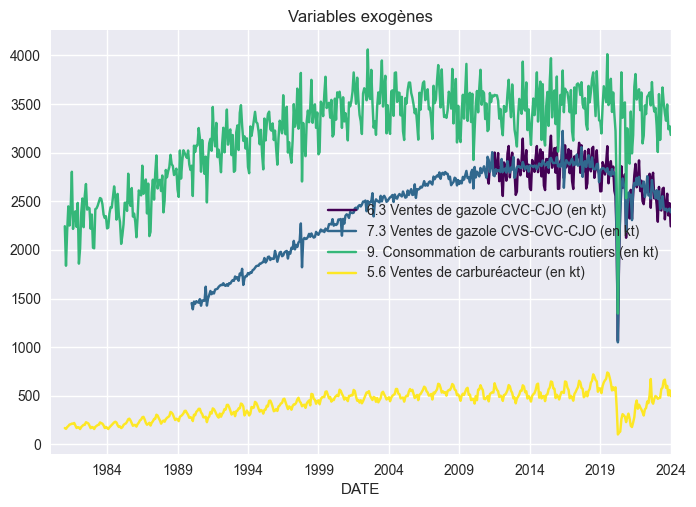

In [358]:
exogenous.plot(title = 'Variables exogènes', colormap= 'viridis');

On va garder les variables 7.3 et 9

In [359]:
exogenous = exogenous.drop(columns = ['6.3 Ventes de gazole CVC-CJO (en kt)','5.6 Ventes de carburéacteur (en kt)'])

In [360]:
exogenous = exogenous.dropna()
exogenous

7.3 Ventes de gazole CVS-CVC-CJO (en kt)  \
DATE                                                   
1990-01-01                                  1452.745   
1990-02-01                                  1389.058   
1990-03-01                                  1468.426   
1990-04-01                                  1445.248   
1990-05-01                                  1472.622   
...                                              ...   
2023-09-01                                  2423.191   
2023-10-01                                  2394.419   
2023-11-01                                  2415.908   
2023-12-01                                  2423.453   
2024-01-01                                  2386.469   

            9. Consommation de carburants routiers (en kt)  
DATE                                                        
1990-01-01                                        2865.000  
1990-02-01                                        2553.600  
1990-03-01                                        3071.000  
1990-04-01                                        3005.800  
1990-05-01                                        3072.900  
...                                                    ...  
2023-09-01                                        3327.462  
2023-10-01                                        3494.708  
2023-11-01                                        3240.082  
2023-12-01                                        3272.015  
2024-01-01                                        3181.754  

[409 rows x 2 columns]

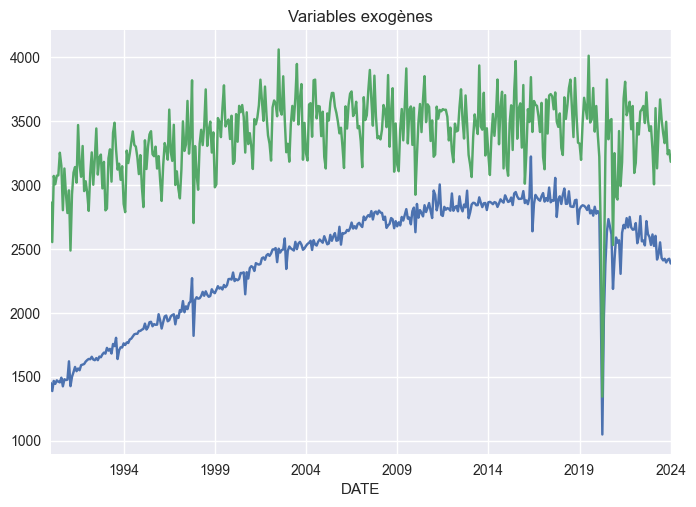

In [361]:
exogenous.plot(title = 'Variables exogènes',legend= False);

Pour plus d'harmonie, nous allons restreindre notre analyse de série temporelle de janvier 1990 à janvier 2024.

## Modèle de base sans variables exogènes

Nous allons tout d'abord étudier un modèle simple sans variables exogènes.

### Train/test split

In [362]:
# Train set
tr_start,tr_end = '1990-01-01','2019-12-01'

# Test set
te_start,te_end = '2020-01-01','2024-01-01'

In [363]:
train_target = data['5.3 Ventes de gazole (en kt)'].loc[tr_start:tr_end]
test_target = data['5.3 Ventes de gazole (en kt)'].loc[te_start:te_end]

In [364]:
start = '1990-01'
target = data['5.3 Ventes de gazole (en kt)'].loc[start:]

In [365]:
train_target = pd.DataFrame(train_target)
test_target = pd.DataFrame(test_target)

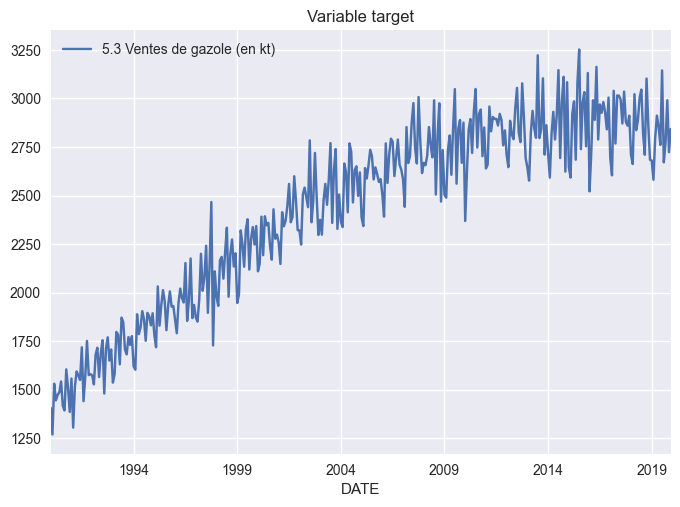

In [366]:
train_target.plot(title = 'Variable target');

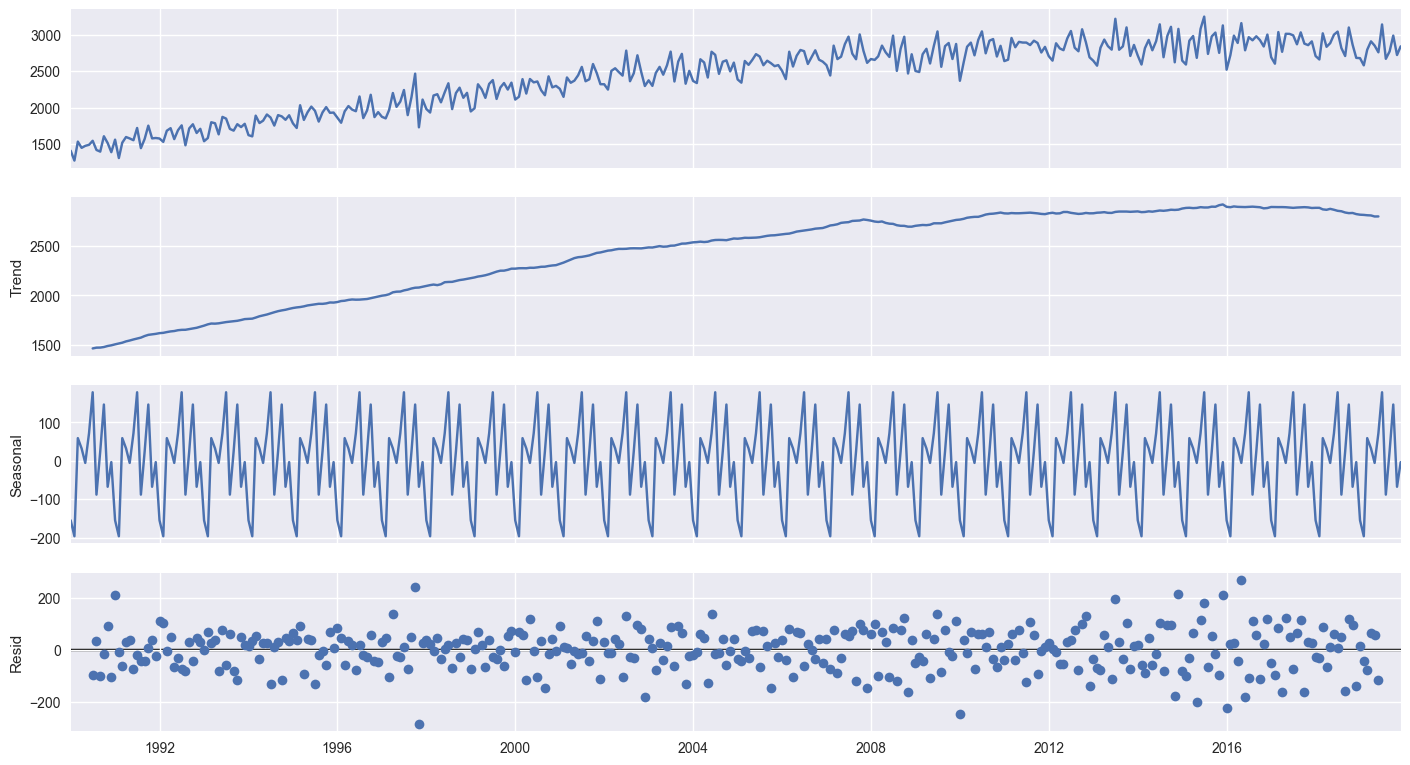

In [367]:
res = sm.tsa.seasonal_decompose(train_target)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

On remarque une saisonnalité annuelle. Une différenciation saisonnière est donc à envisager. 
Les résidus ont l'air d'être centrés en 0, avec néanmoins quelques outliers en 1997 et 2018. 
La série temporelle semble être additive.

### Check stationarity

In [368]:
target_diff = train_target.diff().dropna()

In [369]:
# Original Series Stationarity Test
print('Original Series Stationarity Test')
adfuller_result = adfuller(train_target)
kpss_result = kpss(train_target)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -3.2373157905952845, p-value: 0.01792378446623915
KPSS Statistic: 2.8954828955784335, p-value: 0.01


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\2470568415.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_target)


In [370]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -3.237316  2.895483
p-value    0.017924  0.010000

La série est difference stationary. Appliquons le test à la série différenciée.

In [371]:
print('Differenced series Stationarity Test')
adfuller_result = adfuller(target_diff)
kpss_result = kpss(target_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Differenced series Stationarity Test
ADF Statistic: -3.348446065135373, p-value: 0.01284702574200434
KPSS Statistic: 0.3278505140019448, p-value: 0.1


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\800167438.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(target_diff)


In [372]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -3.348446  0.327851
p-value    0.012847  0.100000

La série différenciée est donc stationnaire. On aura d = 1 dans un modèle ARIMA (ou SARIMA)

### ACF et PACF

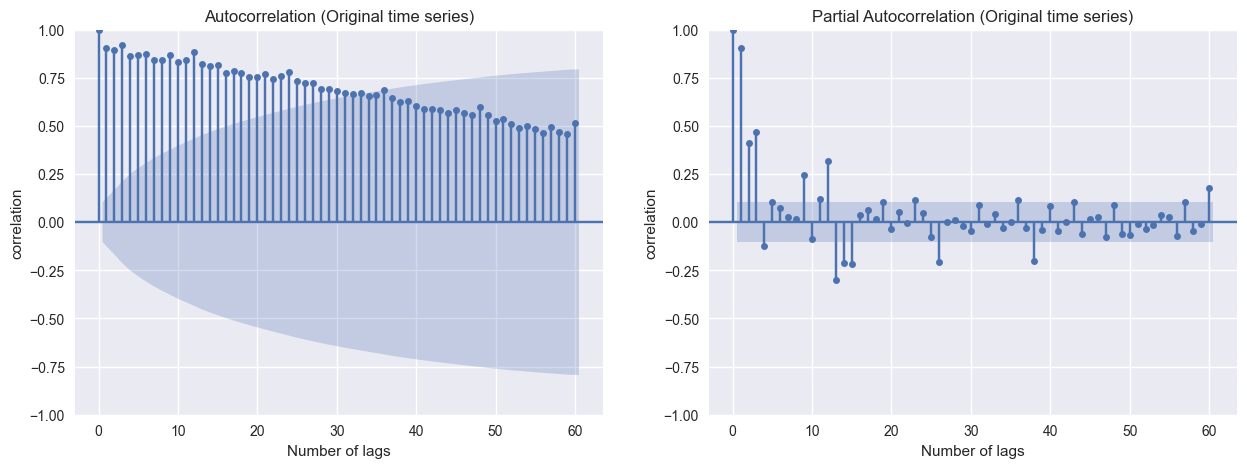

In [373]:
autocorrelation_plots(train_target, 'Original time series', n_lags=60)

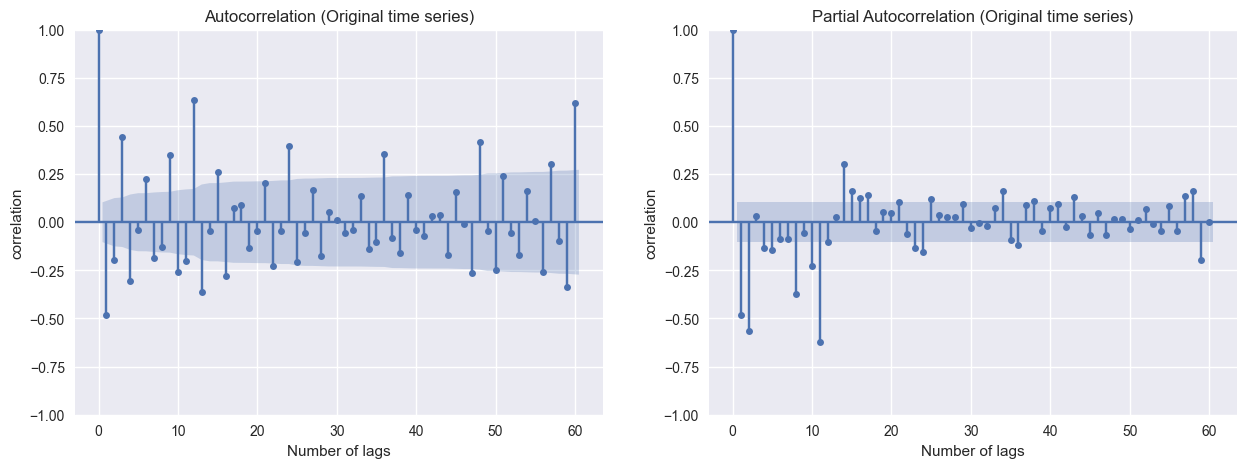

In [374]:
autocorrelation_plots(target_diff, 'Original time series', n_lags=60)

On trouve p = 2, q = 4 et d = 1.
On remarque aussi une saisonnalité annuelle avec des pics importants tous les 12 lags.

In [375]:
target_diff_seasonal = target_diff.diff(12).dropna()

# Stationarity Tests on Combined Differentiated Data
warnings.filterwarnings("ignore")
adfuller_result = adfuller(target_diff_seasonal)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(target_diff_seasonal)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -7.385591712963937, p-value: 8.253327378794855e-11
KPSS Statistic: 0.02935948441794652, p-value: 0.1


In [376]:
test = {}
test['ADF'] = [adfuller_result[0], adfuller_result[1]]
test['KPSS'] = [kpss_result[0], kpss_result[1]]

test = pd.DataFrame(test)
test.index = ['statistic', 'p-value']
test

ADF      KPSS
statistic -7.385592e+00  0.029359
p-value    8.253327e-11  0.100000

La série saisonnièrement différenciée est stationnaire.

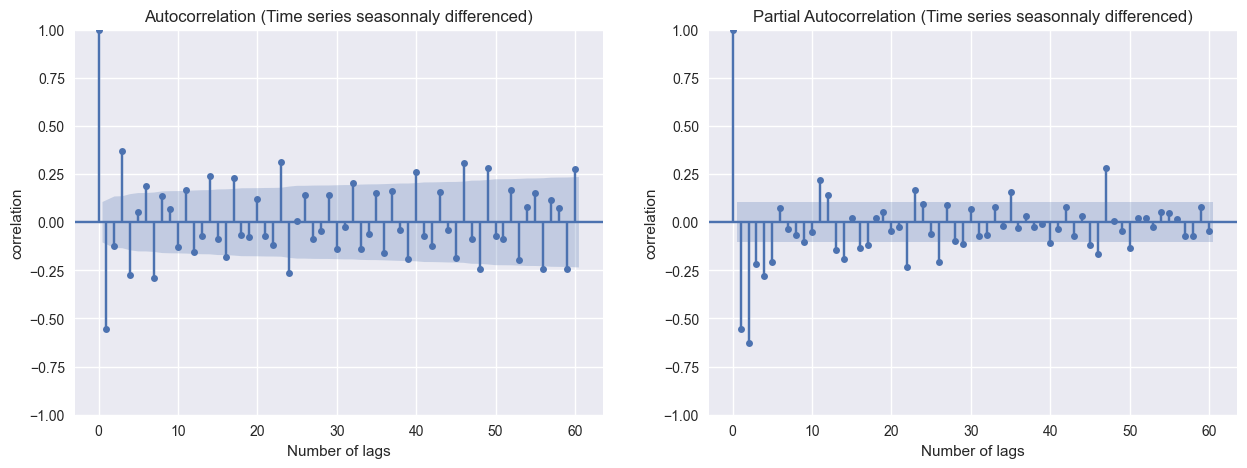

In [377]:
autocorrelation_plots(target_diff_seasonal, 'Time series seasonnaly differenced', n_lags=60)

On trouve P = 5, Q = 1 et D = 1

On aurait donc un modèle SARIMA(2,1,4)x(5, 1, 1)

### Models

In [378]:
model1 = sm.tsa.statespace.SARIMAX(train_target,order=(2,1,4),seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,).fit()
model1.summary()

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         5.3 Ventes de gazole (en kt)   No. Observations:                  360
Model:             SARIMAX(2, 1, 4)x(5, 1, [1], 12)   Log Likelihood               -1982.228
Date:                              Fri, 03 May 2024   AIC                           3990.457
Time:                                      21:21:13   BIC                           4040.498
Sample:                                  01-01-1990   HQIC                          4010.381
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3707      0.022    -62.208      0.000      -1.414      -1.328
ar.L2         -0.9900      0.024    -42.056      0.000      -1.036      -0.944
ma.L1          0.1834      0.052      3.542      0.000       0.082       0.285
ma.L2         -0.2907      0.045     -6.516      0.000      -0.378      -0.203
ma.L3         -0.6420      0.050    -12.747      0.000      -0.741      -0.543
ma.L4          0.3461      0.059      5.880      0.000       0.231       0.461
ar.S.L12      -1.5019      0.053    -28.458      0.000      -1.605      -1.398
ar.S.L24      -1.1803      0.074    -15.899      0.000      -1.326      -1.035
ar.S.L36      -1.0945      0.087    -12.633      0.000      -1.264      -0.925
ar.S.L48      -1.0377      0.080    -12.964      0.000      -1.195      -0.881
ar.S.L60      -0.6175      0.045    -13.715      0.000      -0.706      -0.529
ma.S.L12       0.9675      0.088     10.961      0.000       0.794       1.140
sigma2      4778.9481    409.254     11.677      0.000    3976.825    5581.071
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 9.70
Prob(Q):                              0.91   Prob(JB):                         0.01
Heteroskedasticity (H):               1.47   Skew:                            -0.06
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

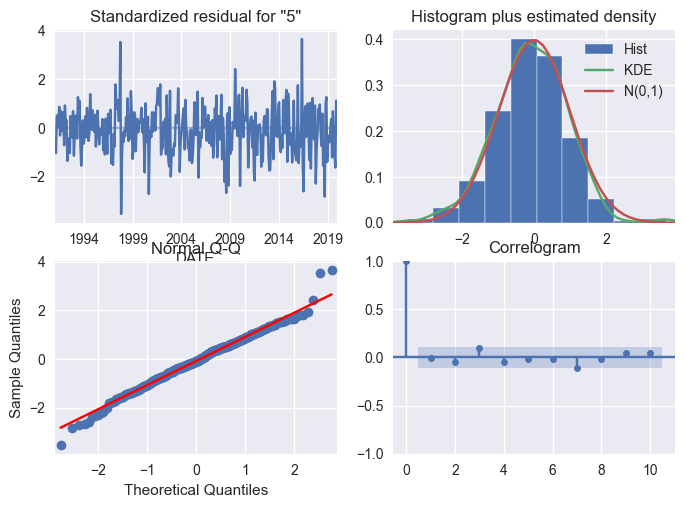

In [379]:
model1.plot_diagnostics()
plt.show()

### Out-of-sample test

SARIMA model MSE:145585.83059554052


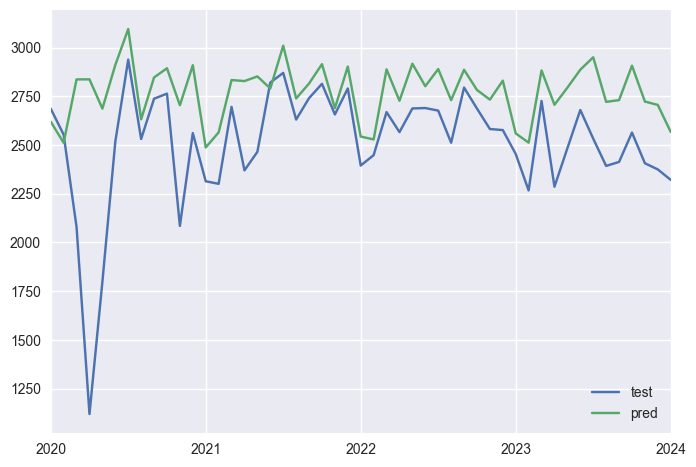

In [380]:
pred1 = model1.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred1)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred1}).plot();plt.show()

## Ajout de variables exogènes

### Analyse des variables exogènes

In [381]:
exogenous

7.3 Ventes de gazole CVS-CVC-CJO (en kt)  \
DATE                                                   
1990-01-01                                  1452.745   
1990-02-01                                  1389.058   
1990-03-01                                  1468.426   
1990-04-01                                  1445.248   
1990-05-01                                  1472.622   
...                                              ...   
2023-09-01                                  2423.191   
2023-10-01                                  2394.419   
2023-11-01                                  2415.908   
2023-12-01                                  2423.453   
2024-01-01                                  2386.469   

            9. Consommation de carburants routiers (en kt)  
DATE                                                        
1990-01-01                                        2865.000  
1990-02-01                                        2553.600  
1990-03-01                                        3071.000  
1990-04-01                                        3005.800  
1990-05-01                                        3072.900  
...                                                    ...  
2023-09-01                                        3327.462  
2023-10-01                                        3494.708  
2023-11-01                                        3240.082  
2023-12-01                                        3272.015  
2024-01-01                                        3181.754  

[409 rows x 2 columns]

In [382]:
exo1 = exogenous.iloc[:,0]
exo2 = exogenous.iloc[:,1]

In [383]:
train_exo1, train_exo2 = exogenous.iloc[:,0].loc[tr_start:tr_end], exogenous.iloc[:,1].loc[tr_start:tr_end]
test_exo1, test_exo2 = exogenous.iloc[:,0].loc[te_start:te_end], exogenous.iloc[:,1].loc[te_start:te_end]

In [384]:
train_exogenous = pd.concat([train_exo1, train_exo2], axis = 1)
test_exogenous = pd.concat([test_exo1, test_exo2], axis = 1)

Plotting the data

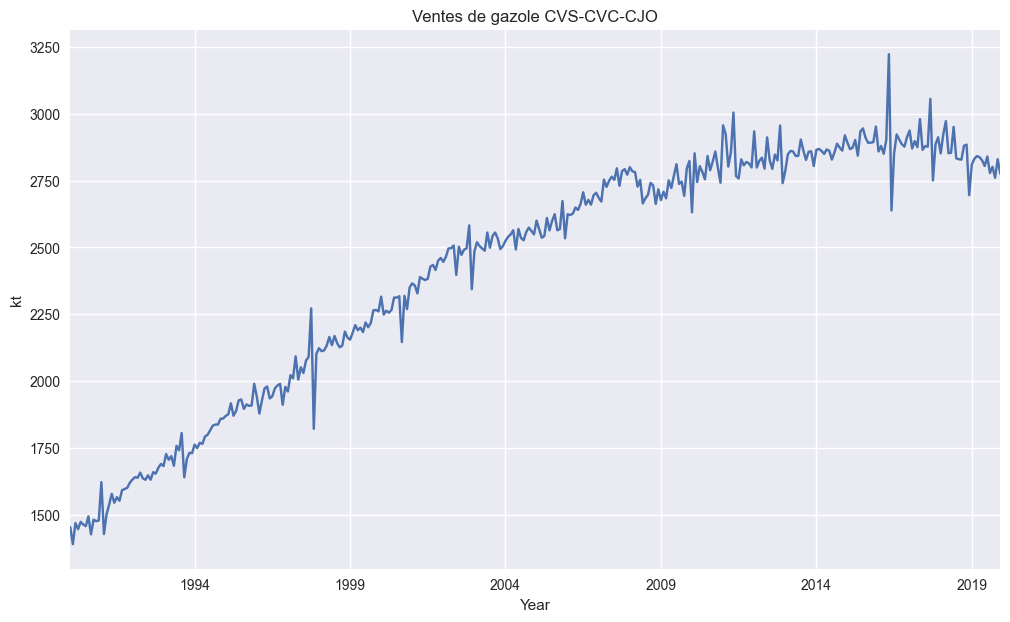

In [385]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
train_exo1.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('kt')
plt.title('Ventes de gazole CVS-CVC-CJO')
plt.show()

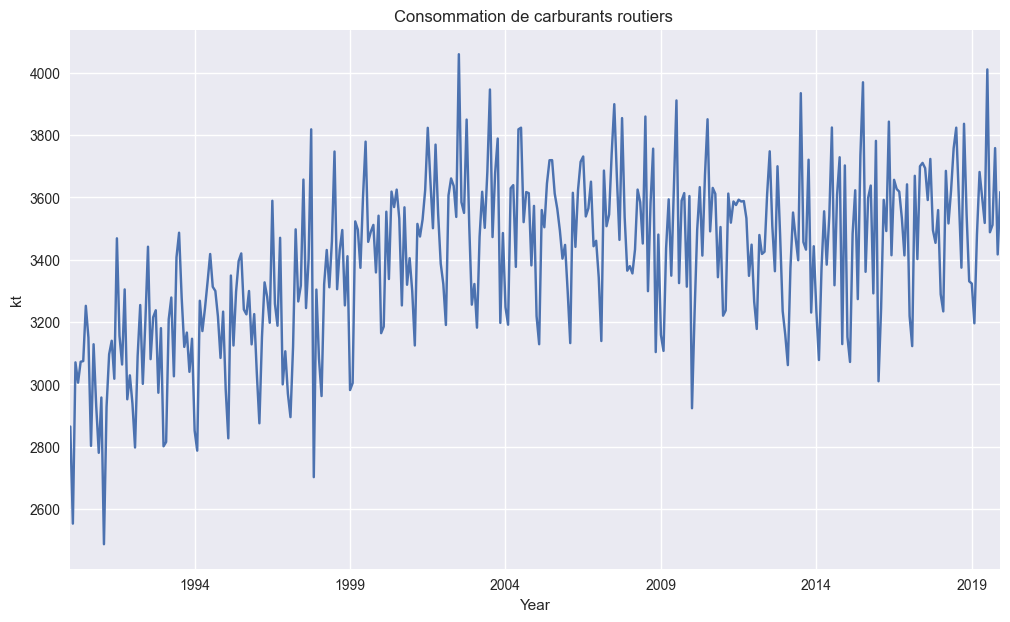

In [386]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
train_exo2.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('kt')
plt.title('Consommation de carburants routiers ')
plt.show()

### Seasonal decomposition

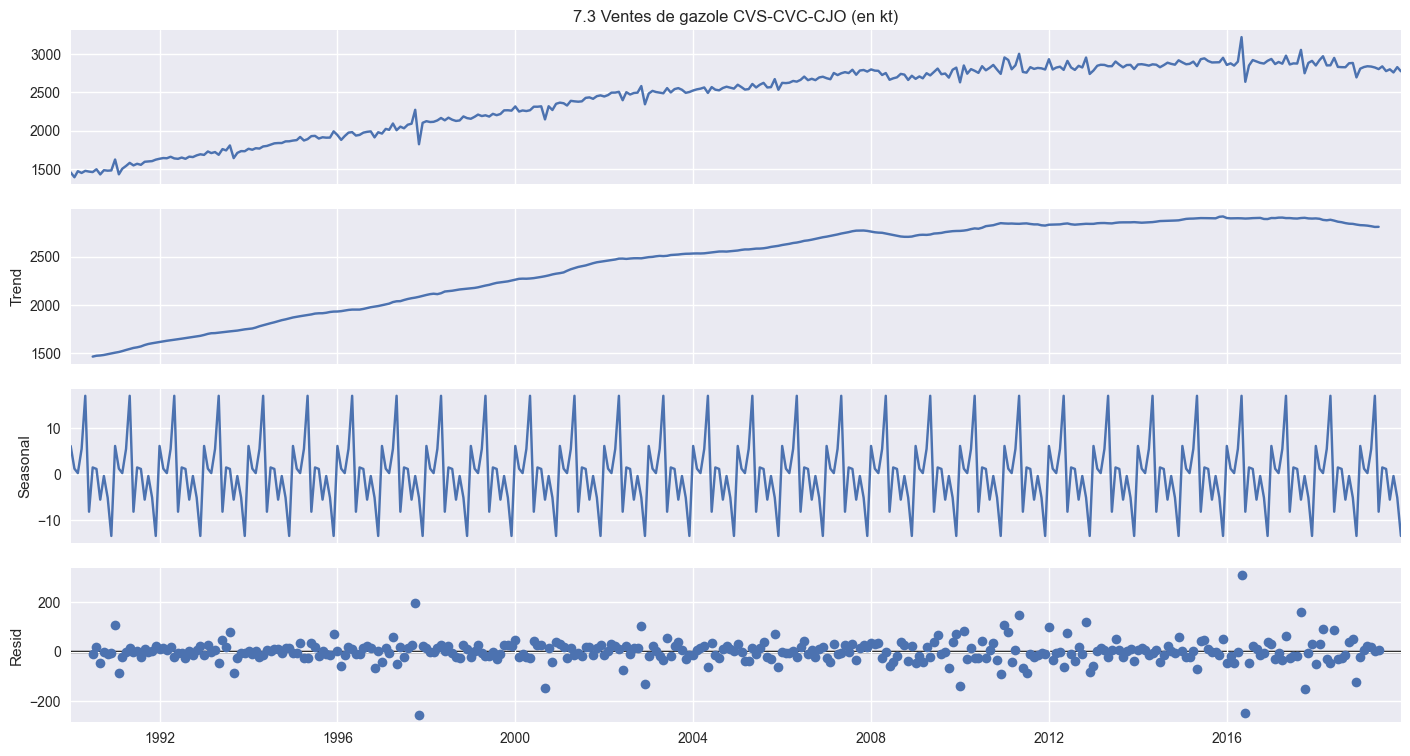

In [387]:
res = sm.tsa.seasonal_decompose(train_exo1)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

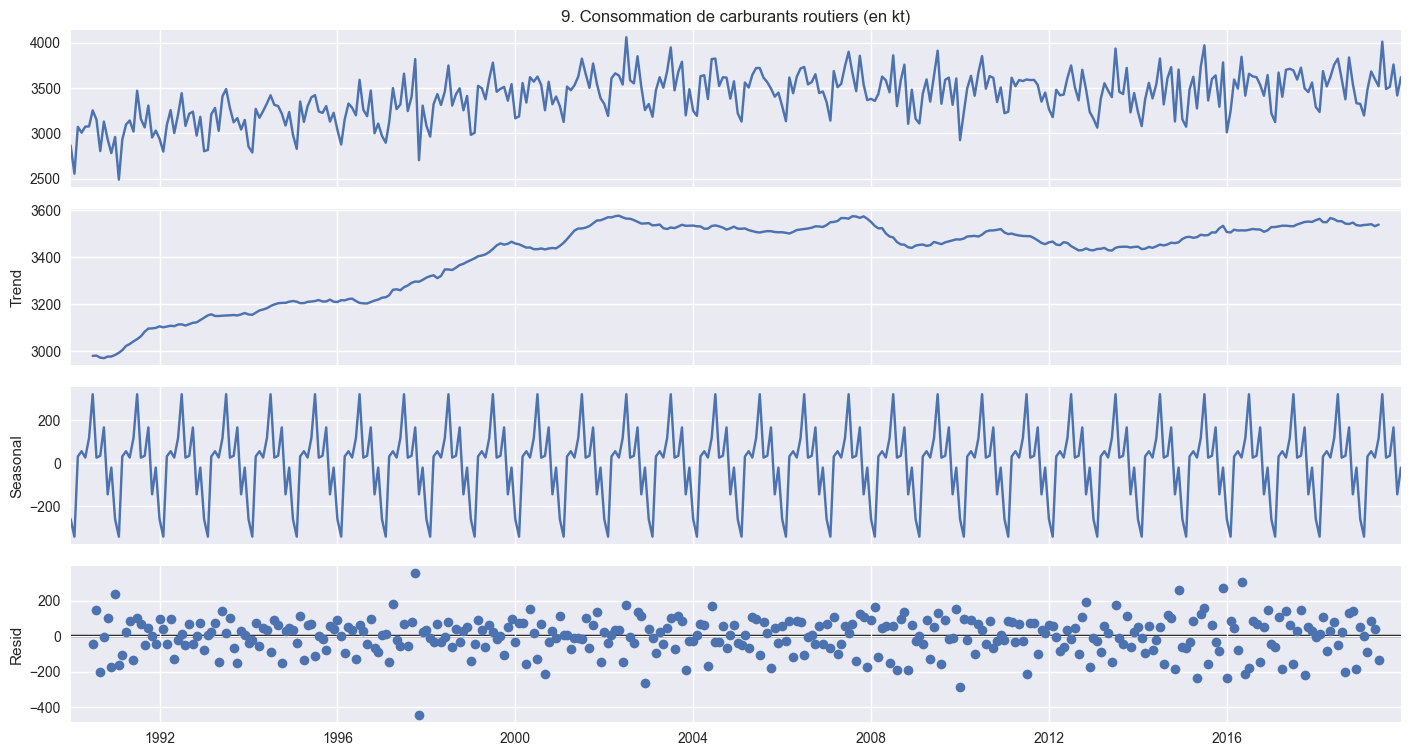

In [388]:
res = sm.tsa.seasonal_decompose(train_exo2)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Check stationarity

EXO1

In [389]:
# Original Series Stationarity Test
print('Original Series Stationarity Test')
adfuller_result = adfuller(train_exo1)
kpss_result = kpss(train_exo1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -4.02410982106885, p-value: 0.0012893958757473232
KPSS Statistic: 2.8898412514371152, p-value: 0.01


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\3110999018.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_exo1)


In [390]:
train_exo1_diff = train_exo1.diff().dropna()

In [391]:
# First order differenced Stationary Test
print('First order differenced Series Stationarity Test')
adfuller_result = adfuller(train_exo1_diff)
kpss_result = kpss(train_exo1_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

First order differenced Series Stationarity Test
ADF Statistic: -17.45919762170937, p-value: 4.607228162293403e-30
KPSS Statistic: 0.3692730647614575, p-value: 0.0903995410510959


First order differenced series is stationary

EXO2

In [392]:
# Original Series Stationarity Test
print('Original Series Stationarity Test')
adfuller_result = adfuller(train_exo2)
kpss_result = kpss(train_exo2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Original Series Stationarity Test
ADF Statistic: -2.9541578299535756, p-value: 0.0394029573309198
KPSS Statistic: 2.2986576540679877, p-value: 0.01


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\2337671819.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_exo2)


La série doit être différenciée

In [393]:
train_exo2_diff = train_exo2.diff().dropna()

In [394]:
# First order differenced Stationary Test
print('First order differenced Series Stationarity Test')
adfuller_result = adfuller(train_exo2_diff)
kpss_result = kpss(train_exo2_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

First order differenced Series Stationarity Test
ADF Statistic: -4.832804439355352, p-value: 4.704901997388104e-05
KPSS Statistic: 0.1252997691493347, p-value: 0.1


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\3504884602.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_exo2_diff)


Both time series are stationary at the 1st order

Both time series are stationary at the 1st order

### ACF et PACF

EXO1

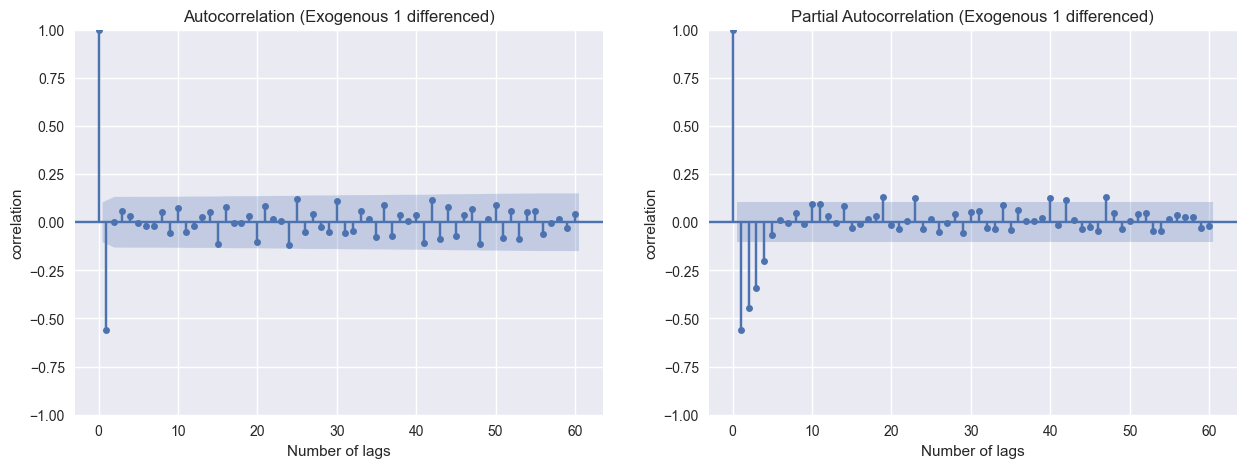

In [395]:
autocorrelation_plots(train_exo1_diff, 'Exogenous 1 differenced', n_lags=60)

On trouve p= 4 et q = 1 et d = 1. Gradual decay in the PACF and sharp cut off in the ACF => stationary Moving Average.

Pas  de signe apparent de saisonnalité sur les ACF et PACF. ARIMA(4,1,1)

EXO2

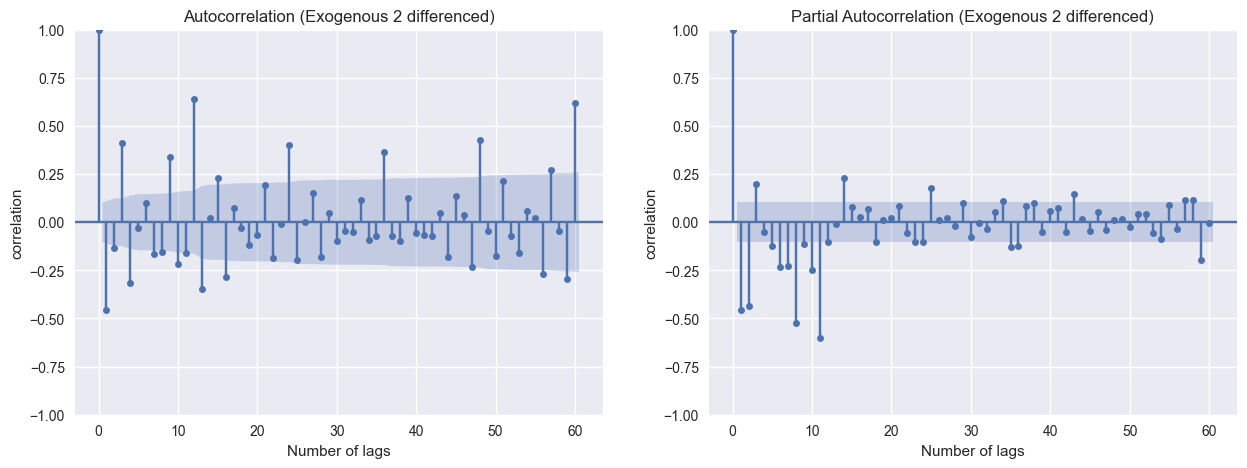

In [396]:
autocorrelation_plots(train_exo2_diff, 'Exogenous 2 differenced', n_lags=60)

On trouve une saisonnalité dans l'ACF => modèle SARIMA. On trouve p=3, q = 4 et d= 1

In [397]:
train_exo2_diff_seasonal = train_exo2_diff.diff(12).dropna()

In [398]:
# First seasonal order differenced Stationary Test
print('First order differenced Series Stationarity Test')
adfuller_result = adfuller(train_exo2_diff_seasonal)
kpss_result = kpss(train_exo2_diff_seasonal)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

First order differenced Series Stationarity Test
ADF Statistic: -7.731335534453822, p-value: 1.123297802871001e-11
KPSS Statistic: 0.04456826303052144, p-value: 0.1


C:\Users\andri\AppData\Local\Temp\ipykernel_12760\2726244121.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_exo2_diff_seasonal)


La série différenciée saisonnièrement est stationnaire.

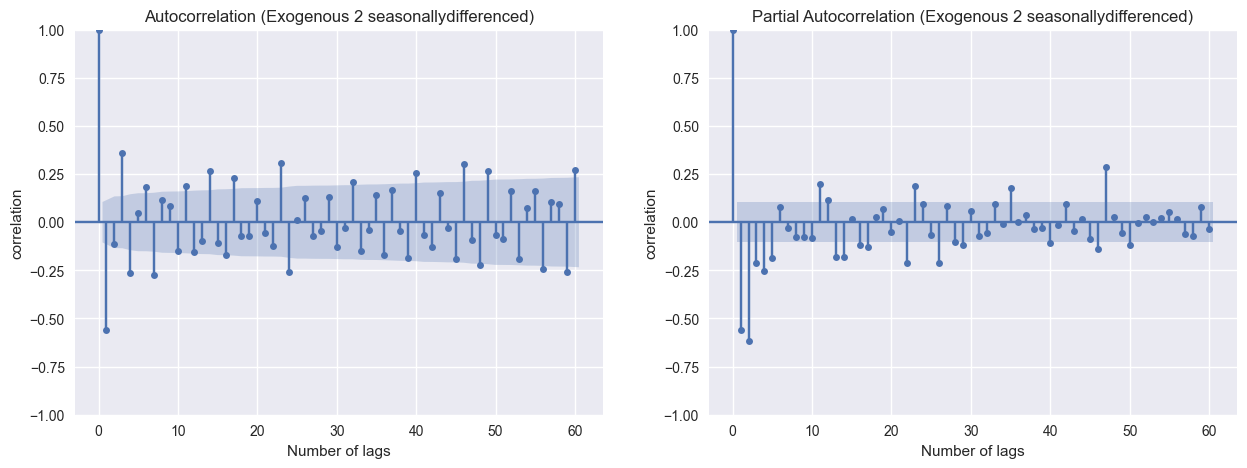

In [399]:
autocorrelation_plots(train_exo2_diff_seasonal, 'Exogenous 2 seasonallydifferenced', n_lags=60)

On trouve P = 5, Q = 1 et D = 1

SARIMA(3,1,4)x(5,1,1,12)

### Models

In [400]:
model_exo1 = sm.tsa.statespace.SARIMAX(train_exo1,order=(4,1,1),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()
model_exo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:     7.3 Ventes de gazole CVS-CVC-CJO (en kt)   No. Observations:                  360
Model:                                     SARIMAX(4, 1, 1)   Log Likelihood               -1944.918
Date:                                      Fri, 03 May 2024   AIC                           3901.837
Time:                                              21:21:20   BIC                           3925.137
Sample:                                          01-01-1990   HQIC                          3911.102
                                               - 12-01-2019                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9526      0.345     -2.762      0.006      -1.629      -0.277
ar.L2         -0.7612      0.320     -2.381      0.017      -1.388      -0.135
ar.L3         -0.4358      0.239     -1.824      0.068      -0.904       0.033
ar.L4         -0.1449      0.113     -1.279      0.201      -0.367       0.077
ma.L1         -0.0231      0.352     -0.066      0.948      -0.713       0.667
sigma2      2963.2982    127.232     23.291      0.000    2713.928    3212.668
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):               843.26
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

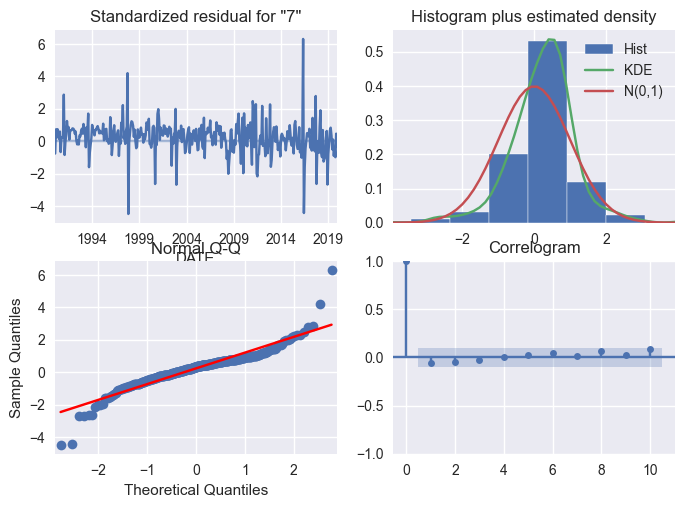

In [401]:
model_exo1.plot_diagnostics()
plt.show()

Modele pas bon, on décide de faire un grid search

In [402]:
import pmdarima as pm

# Create auto_arima model
model1_bis = pm.auto_arima(train_exo1, #time series
                      seasonal=False, # is the time series seasonal
                      m=12, # the seasonal period 
                      d=1, # non-seasonal difference order
                 	  max_p=3, # max value of p to test 
                      max_q=3, # max value of p to test
                      trace=True, # prints the information_criterion for each model it fits
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model1_bis.summary())

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3878.673, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4143.683, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4011.781, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3914.354, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4142.499, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3914.497, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3883.940, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3879.125, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3897.066, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3886.029, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3880.053, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3891.282, Time=0.15 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.112 seconds
         

In [403]:
model_exo2 = sm.tsa.statespace.SARIMAX(train_exo2,order=(3,1,4), seasonal_order = (5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()
model_exo2.summary()

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                             SARIMAX Results                                              
==========================================================================================================
Dep. Variable:     9. Consommation de carburants routiers (en kt)   No. Observations:                  360
Model:                           SARIMAX(3, 1, 4)x(5, 1, [1], 12)   Log Likelihood               -2081.476
Date:                                            Fri, 03 May 2024   AIC                           4190.952
Time:                                                    21:22:56   BIC                           4244.842
Sample:                                                01-01-1990   HQIC                          4212.409
                                                     - 12-01-2019                                         
Covariance Type:                                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7619      0.173    -10.172      0.000      -2.101      -1.422
ar.L2         -1.6948      0.199     -8.533      0.000      -2.084      -1.305
ar.L3         -0.6048      0.172     -3.515      0.000      -0.942      -0.268
ma.L1          0.6227      0.187      3.338      0.001       0.257       0.988
ma.L2          0.0781      0.064      1.215      0.224      -0.048       0.204
ma.L3         -0.8266      0.062    -13.435      0.000      -0.947      -0.706
ma.L4         -0.2933      0.174     -1.689      0.091      -0.634       0.047
ar.S.L12      -1.6347      0.071    -22.994      0.000      -1.774      -1.495
ar.S.L24      -1.3362      0.111    -12.041      0.000      -1.554      -1.119
ar.S.L36      -1.0675      0.131     -8.118      0.000      -1.325      -0.810
ar.S.L48      -0.8847      0.115     -7.724      0.000      -1.109      -0.660
ar.S.L60      -0.5136      0.060     -8.583      0.000      -0.631      -0.396
ma.S.L12       0.9689      0.109      8.898      0.000       0.756       1.182
sigma2      9486.4301    938.632     10.107      0.000    7646.745    1.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.14   Jarque-Bera (JB):                15.43
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.04
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

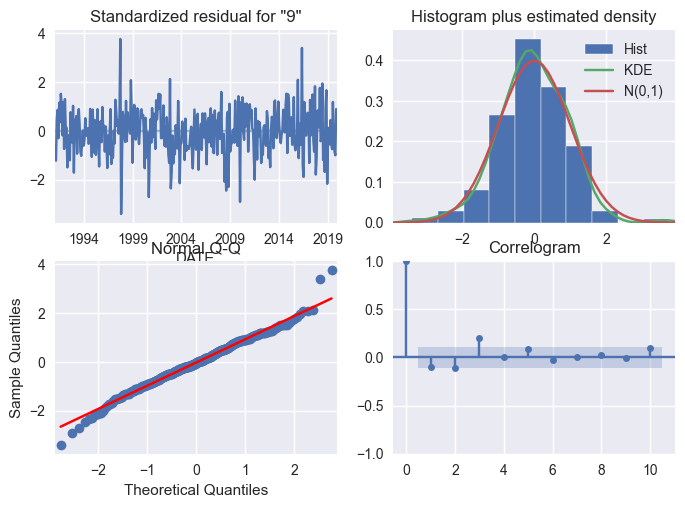

In [404]:
model_exo2.plot_diagnostics()
plt.show()

### Out-of-sample test

SARIMA model MSE:151837.7834776191


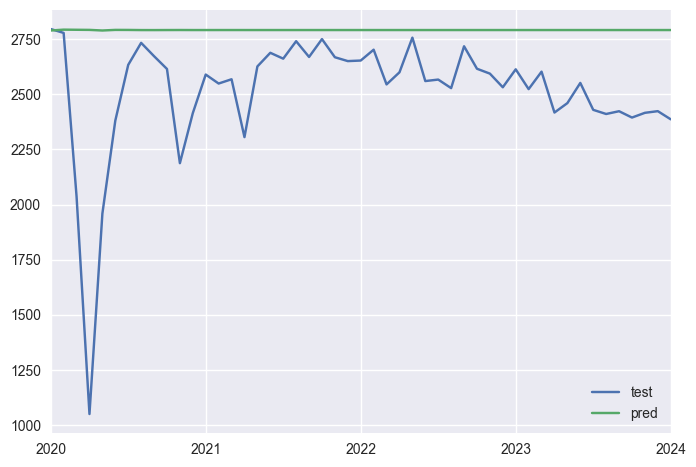

In [405]:
pred_exo1 = model_exo1.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_exo1,pred_exo1)))

pd.DataFrame({'test':test_exo1.values.flatten(),'pred': pred_exo1}).plot();plt.show()

SARIMA model MSE:231446.1350281272


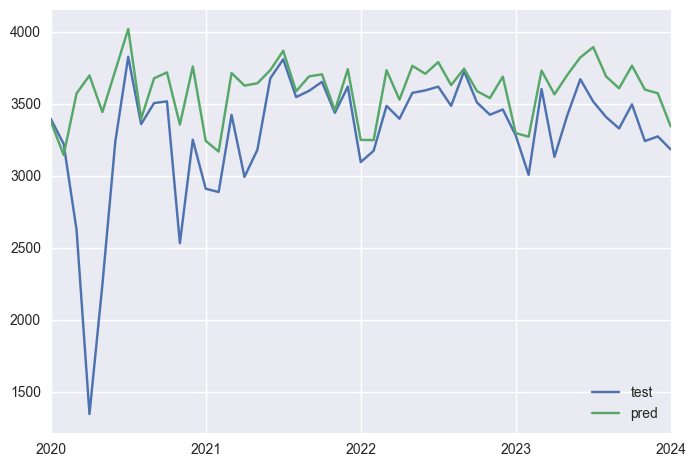

In [406]:
pred_exo2 = model_exo2.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_exo2,pred_exo2)))

pd.DataFrame({'test':test_exo2.values.flatten(),'pred':pred_exo2}).plot();plt.show()

### Get Full forecast for exogenous variables

Forecast for EXO1

In [407]:
final_model_exo1 = sm.tsa.statespace.SARIMAX(exo1,order=(2,1,2),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()

c:\Users\andri\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [408]:
pred_exo1 = final_model_exo1.forecast(steps = 12)
pred_exo1

2024-02-01    2409.236595
2024-03-01    2435.754968
2024-04-01    2431.394570
2024-05-01    2445.594387
2024-06-01    2435.885098
2024-07-01    2447.522118
2024-08-01    2436.831422
2024-09-01    2447.863402
2024-10-01    2437.066379
2024-11-01    2447.886947
2024-12-01    2437.158183
2025-01-01    2447.847225
Freq: MS, Name: predicted_mean, dtype: float64

In [409]:
final_model_exo2 = sm.tsa.statespace.SARIMAX(exo2,order=(2,1,2),
                                 enforce_stationarity=True, enforce_invertibility=False).fit()

In [410]:
pred_exo2 = final_model_exo2.forecast(steps = 12)
pred_exo2

2024-02-01    3165.557064
2024-03-01    3238.423161
2024-04-01    3173.736625
2024-05-01    3205.465146
2024-06-01    3202.619944
2024-07-01    3191.483572
2024-08-01    3203.707476
2024-09-01    3196.554771
2024-10-01    3198.232472
2024-11-01    3199.721824
2024-12-01    3197.517102
2025-01-01    3199.035297
Freq: MS, Name: predicted_mean, dtype: float64

## Modèle avec Variables exogènes

### Utilisation de la variable EXO1

In [411]:
import warnings
warnings.filterwarnings("ignore")

In [414]:
model_with_exo1 = sm.tsa.statespace.SARIMAX(train_target,order=(2,1,4),seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=train_exo1).fit()
model_with_exo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         5.3 Ventes de gazole (en kt)   No. Observations:                  360
Model:             SARIMAX(2, 1, 4)x(5, 1, [1], 12)   Log Likelihood               -1794.084
Date:                              Fri, 03 May 2024   AIC                           3616.167
Time:                                      21:31:59   BIC                           3670.058
Sample:                                  01-01-1990   HQIC                          3637.624
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
7.3 Ventes de gazole CVS-CVC-CJO (en kt)     0.9442      0.029     32.169      0.000       0.887       1.002
ar.L1                                       -1.1167      0.103    -10.888      0.000      -1.318      -0.916
ar.L2                                       -0.7507      0.094     -8.012      0.000      -0.934      -0.567
ma.L1                                       -0.1049      0.119     -0.881      0.378      -0.338       0.128
ma.L2                                       -0.4339      0.122     -3.570      0.000      -0.672      -0.196
ma.L3                                       -0.4388      0.127     -3.448      0.001      -0.688      -0.189
ma.L4                                        0.0178      0.077      0.231      0.818      -0.134       0.170
ar.S.L12                                    -1.3977      0.050    -27.883      0.000      -1.496      -1.299
ar.S.L24                                    -1.0417      0.072    -14.524      0.000      -1.182      -0.901
ar.S.L36                                    -1.0914      0.078    -13.964      0.000      -1.245      -0.938
ar.S.L48                                    -1.1412      0.077    -14.869      0.000      -1.292      -0.991
ar.S.L60                                    -0.6922      0.044    -15.660      0.000      -0.779      -0.606
ma.S.L12                                     0.9796      0.119      8.253      0.000       0.747       1.212
sigma2                                    1588.1828    167.669      9.472      0.000    1259.557    1916.809
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.08
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Amélioration des critères AIC et BIC

SARIMA model MSE:2592.4760832120037


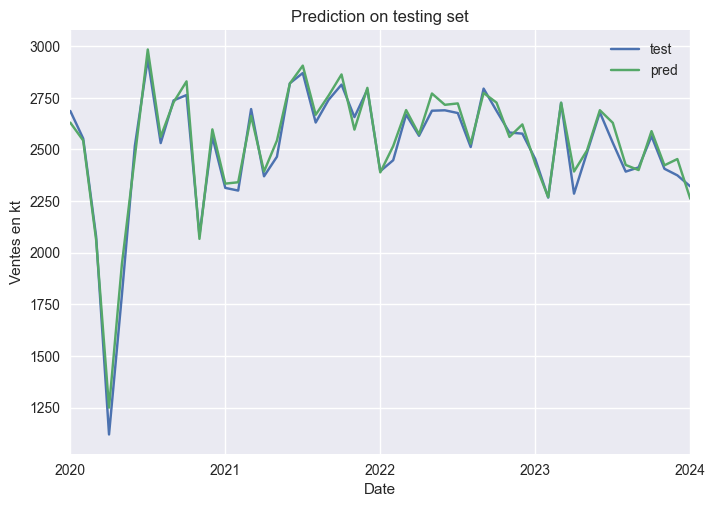

In [413]:
pred_model_with_exo1 = model_with_exo1.predict(tr_end,te_end,exog=test_exo1)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred_model_with_exo1)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred_model_with_exo1}).plot(title = 'Prediction on testing set', xlabel = 'Date', ylabel = 'Ventes en kt');plt.show()

### Modèle avec les deux variables exogènes

In [416]:
model_with_exogenous = sm.tsa.statespace.SARIMAX(train_target,order=(2,1,4),seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=train_exogenous).fit()
model_with_exogenous.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         5.3 Ventes de gazole (en kt)   No. Observations:                  360
Model:             SARIMAX(2, 1, 4)x(5, 1, [1], 12)   Log Likelihood               -1470.640
Date:                              Fri, 03 May 2024   AIC                           2971.280
Time:                                      21:42:09   BIC                           3029.019
Sample:                                  01-01-1990   HQIC                          2994.269
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
7.3 Ventes de gazole CVS-CVC-CJO (en kt)           0.0369      0.019      1.981      0.048       0.000       0.073
9. Consommation de carburants routiers (en kt)     0.7327      0.011     69.730      0.000       0.712       0.753
ar.L1                                             -0.5039      0.461     -1.092      0.275      -1.408       0.400
ar.L2                                              0.3173      0.438      0.724      0.469      -0.542       1.177
ma.L1                                             -0.3315      0.465     -0.713      0.476      -1.242       0.579
ma.L2                                             -0.5356      0.132     -4.068      0.000      -0.794      -0.278
ma.L3                                              0.4387      0.293      1.496      0.135      -0.136       1.013
ma.L4                                             -0.1814      0.109     -1.666      0.096      -0.395       0.032
ar.S.L12                                           0.3267      0.112      2.917      0.004       0.107       0.546
ar.S.L24                                          -0.0036      0.068     -0.053      0.958      -0.137       0.130
ar.S.L36                                           0.2363      0.063      3.738      0.000       0.112       0.360
ar.S.L48                                          -0.0397      0.074     -0.538      0.590      -0.184       0.105
ar.S.L60                                           0.3355      0.069      4.882      0.000       0.201       0.470
ma.S.L12                                          -0.8194      0.115     -7.146      0.000      -1.044      -0.595
sigma2                                           273.7407     20.221     13.537      0.000     234.107     313.374
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                14.80
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:1066.1046058218174


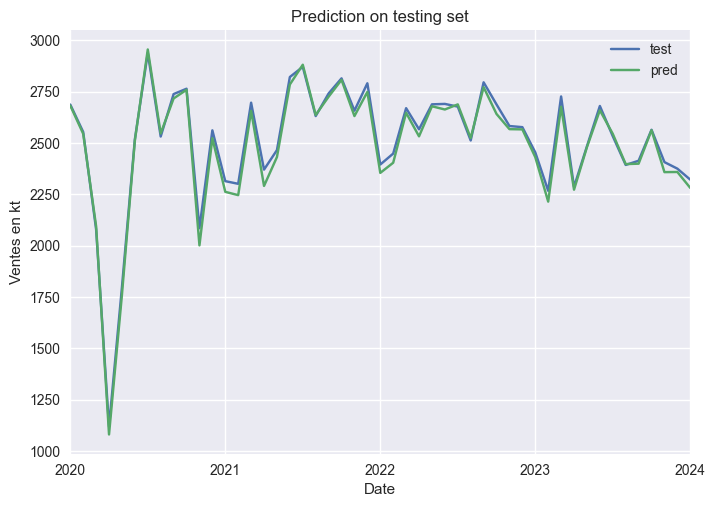

In [417]:
pred_model_with_exogenous = model_with_exogenous.predict(tr_end,te_end,exog=test_exogenous)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_target,pred_model_with_exogenous)))

pd.DataFrame({'test':test_target.values.flatten(),'pred':pred_model_with_exogenous}).plot(title = 'Prediction on testing set', xlabel = 'Date', ylabel = 'Ventes en kt');plt.show()

## Prédictions finales

In [418]:
pred_exogenous = pd.concat([pred_exo1, pred_exo2], axis = 1)
pred_exogenous

predicted_mean  predicted_mean
2024-02-01     2409.236595     3165.557064
2024-03-01     2435.754968     3238.423161
2024-04-01     2431.394570     3173.736625
2024-05-01     2445.594387     3205.465146
2024-06-01     2435.885098     3202.619944
2024-07-01     2447.522118     3191.483572
2024-08-01     2436.831422     3203.707476
2024-09-01     2447.863402     3196.554771
2024-10-01     2437.066379     3198.232472
2024-11-01     2447.886947     3199.721824
2024-12-01     2437.158183     3197.517102
2025-01-01     2447.847225     3199.035297

In [419]:
final_model_target = sm.tsa.statespace.SARIMAX(target,order=(2,1,4), seasonal_order=(5,1,1,12),
                                 enforce_stationarity=True, enforce_invertibility=False,exog=exogenous).fit()
final_model_target.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         5.3 Ventes de gazole (en kt)   No. Observations:                  409
Model:             SARIMAX(2, 1, 4)x(5, 1, [1], 12)   Log Likelihood               -1696.286
Date:                              Fri, 03 May 2024   AIC                           3422.573
Time:                                      22:03:20   BIC                           3482.294
Sample:                                  01-01-1990   HQIC                          3446.232
                                       - 01-01-2024                                         
Covariance Type:                                opg                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
7.3 Ventes de gazole CVS-CVC-CJO (en kt)           0.0322      0.015      2.095      0.036       0.002       0.062
9. Consommation de carburants routiers (en kt)     0.7241      0.010     69.815      0.000       0.704       0.744
ar.L1                                             -0.1672      0.359     -0.466      0.641      -0.870       0.536
ar.L2                                              0.7375      0.339      2.175      0.030       0.073       1.402
ma.L1                                             -0.6257      0.368     -1.699      0.089      -1.348       0.096
ma.L2                                             -0.7465      0.135     -5.518      0.000      -1.012      -0.481
ma.L3                                              0.6869      0.261      2.630      0.009       0.175       1.199
ma.L4                                             -0.1900      0.071     -2.662      0.008      -0.330      -0.050
ar.S.L12                                           0.3165      0.111      2.856      0.004       0.099       0.534
ar.S.L24                                          -0.0377      0.067     -0.561      0.575      -0.169       0.094
ar.S.L36                                           0.2247      0.066      3.402      0.001       0.095       0.354
ar.S.L48                                          -0.0480      0.071     -0.672      0.502      -0.188       0.092
ar.S.L60                                           0.3243      0.063      5.188      0.000       0.202       0.447
ma.S.L12                                          -0.7643      0.103     -7.411      0.000      -0.966      -0.562
sigma2                                           322.9256     27.474     11.754      0.000     269.077     376.774
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                19.27
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.01
Prob(H) (two-sided):                  0.99   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

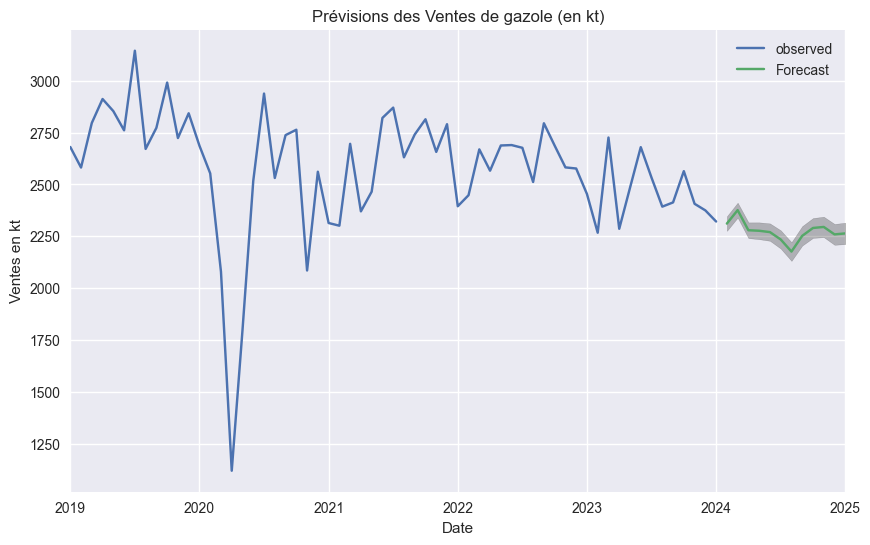

In [421]:
final_forecast = final_model_target.get_forecast(steps = 12, exog = pred_exogenous)
final_forecast_ci = final_forecast.conf_int()

ax = target.loc['2019-01-01':].plot(label='observed', figsize=(10, 6))
final_forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(final_forecast_ci.index,
                final_forecast_ci.iloc[:, 0],
                final_forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('Prévisions des Ventes de gazole (en kt)')
ax.set_xlabel('Date')
ax.set_ylabel('Ventes en kt')

plt.legend()
plt.show()